In [1]:
import pandas as pd
import geopandas as gp 
import json
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(rc={'figure.figsize':(12,8)})
%matplotlib inline
from tqdm import tqdm
import glob
import numpy as np
from scipy.stats import pearsonr
from scipy.stats import linregress
import pickle as pkl

In [2]:
with open('../mappings/Bipartite_Drug_graph.pkl','rb') as f:
    drug_association_graph  = pkl.load(f)

with open('../mappings/Bipartite_Drug_category_graph.pkl','rb') as f:
    drug_cat_association_graph  = pkl.load(f)

In [3]:
def cleanStringofUTF(string):
    cleaned = string.encode('utf-8').replace('\xe8','e').replace('\xf6','o')
    return cleaned

def enrichdrugs(chem_dict , drugs):
    diabetes_drug_words = [drugs[k]['name'].lower() for k in drugs]
    for drug in chem_dict:
        Name = chem_dict[drug]['name'].replace('(','').replace(')','')
        slot1 = Name.lower().split('/')
        slot2 = Name.lower().split(' ')
        slot3 = Name.lower().split(' & ')
        common1 = set(diabetes_drug_words).intersection(slot1)
        common2 = set(diabetes_drug_words).intersection(slot2)
        common3 = set(diabetes_drug_words).intersection(slot3)
        
        if len(common1) > 0 or len(common2) > 0 or len(common3) > 0:
#             print common1 , common2 , common3
            drugs[chem_dict[drug]['code']] = {'disease':'' , 'disease_given_drug':0.0 , 'matched_disease':'', 'name':chem_dict[drug]['name'].strip() }

            
            
def makeChemDict(BNF_Chem):
    chem_dict = {}
    for index, row in BNF_Chem.iterrows():
        chem_dict[row['UNII_drugbank']] = {}
        chem_dict[row['UNII_drugbank']]['name'] = row['NAME']
        chem_dict[row['UNII_drugbank']]['code'] = row['BNF_code']
    return chem_dict
    
def getDrugCategory(categorylist, BNF_Chem, drugbankDict):
    allMatched = []
    drugs = {}
    chem_dict = makeChemDict(BNF_Chem)
    
    for k in drugbankDict:
        if len(drugbankDict[k]['Categories']) > 0:
            for cat in drugbankDict[k]['Categories']:
                matched_memo = []
                catString = cat.values()[0]#.split('\u2014')[-1]
                t = catString.lower().strip()
                for categoryString in categorylist:
                    categoryString = categoryString.lower()
                    if t.find(categoryString) >= 0:
                        matched_memo.append(categoryString)
                if k in chem_dict:
                    if len(matched_memo) > 0:# == len(categorylist):
                        allMatched.append(k)
#                         print chem_dict[k]
                        drugs[chem_dict[k]['code']] = {}
                        drugs[chem_dict[k]['code']]['name'] = chem_dict[k]['name']
                        drugs[chem_dict[k]['code']]['matched_cat'] = categorylist
    enrichdrugs(chem_dict,drugs)               
    return list(set(allMatched)) , drugs


def getDrugforDiseaseDrugbank(categorylist, BNF_Chem, drugbankDict):
    allMatched = []
    drugs = {}
    chem_dict = makeChemDict(BNF_Chem)
    
    for k in drugbankDict:
        if len(drugbankDict[k]['Associations']) > 0:
            for cat in drugbankDict[k]['Associations']:
                matched_memo = []
                catString = cat.values()[0]
                t = catString.lower().strip()
                for categoryString in categorylist:
                    categoryString = categoryString.lower()
                    if t.find(categoryString) >= 0:
                        matched_memo.append(categoryString)
                if k in chem_dict:
                    if len(matched_memo) > 0:
                        allMatched.append(k)
#                         print chem_dict[k]
                        drugs[chem_dict[k]['code']] = {}
                        drugs[chem_dict[k]['code']]['name'] = chem_dict[k]['name']
                        drugs[chem_dict[k]['code']]['matched_cat'] = categorylist
    enrichdrugs(chem_dict,drugs)               
    return  allMatched , drugs


def findDrugsForDisease(Graph, Disease, BNF_Chem ):#,threshProb):
    chem_dict = makeChemDict(BNF_Chem)
    drugs = {}
    for e in Graph.edges(data=True):
        if (cleanStringofUTF(e[1]).lower().find(Disease.lower()) >=0) or (cleanStringofUTF(e[0]).lower().find(Disease.lower()) >= 0) :
            drugNode = ''
            matchedDisease = ''
            if Graph.node[e[0]]['type'] == 'symptom':
                drugNode = e[1]
                matchedDisease = e[0]
            else:
                drugNode = e[0]
                matchedDisease = e[1]
            drugs[Graph.node[drugNode]['Id']] = {}
            drugs[Graph.node[drugNode]['Id']]['name'] = drugNode
            drugs[Graph.node[drugNode]['Id']]['matched_disease'] = matchedDisease
            drugs[Graph.node[drugNode]['Id']]['disease'] = Disease
    enrichdrugs(chem_dict,drugs)
    return drugs


def generateConfidence(drugs,Graph):
    shared = []
    All = []
    denom = max(Graph.degree().values())
    for d in drugs:
        name = drugs[d]['name']
        for e in Graph.edges(data=True):
            if Graph.node[e[0]]['type'] == 'symptom':
                if e[1] == name:
                    shared.append(Graph.degree()[e[1]]-1)
                else:
                    continue
            else:
                
                if e[0] == name:
                    shared.append(Graph.degree()[e[0]]-1)
                else:
                    continue
#     shared = [float(k) for k in shared]
    num = [k for k in shared if k > 1]

    return float(len(num)+1.0)/float(len(shared)+1.0)
#     return float(len(num))/float(len(shared)) * 10.0
#     return len(num)
                
                
def findDrugsForCategory(Graph, Cat, BNF_Chem ):#,threshProb):
    chem_dict = makeChemDict(BNF_Chem)
    drugs = {}
    for e in Graph.edges(data=True):
        if (cleanStringofUTF(e[1]).lower().find(Cat.lower()) >=0) or (cleanStringofUTF(e[0]).lower().find(Cat.lower()) >= 0) :
            drugNode = ''
            matchedDisease = ''
            if Graph.node[e[0]]['type'] == 'category':
                drugNode = e[1]
                matchedDisease = e[0]
            else:
                drugNode = e[0]
                matchedDisease = e[1]
            print Graph.node[drugNode]['Id']
            drugs[Graph.node[drugNode]['Id']] = {}
            drugs[Graph.node[drugNode]['Id']]['name'] = drugNode
            drugs[Graph.node[drugNode]['Id']]['matched_cat'] = matchedDisease
            drugs[Graph.node[drugNode]['Id']]['category'] = Cat
    enrichdrugs(chem_dict,drugs)
    return drugs


In [4]:
files = glob.glob('../../BL_Work/openPrescribe/serialized/*.gz')
print(files)

['../../BL_Work/openPrescribe/serialized/201810.gz', '../../BL_Work/openPrescribe/serialized/201710.gz', '../../BL_Work/openPrescribe/serialized/201203.gz', '../../BL_Work/openPrescribe/serialized/201110.gz', '../../BL_Work/openPrescribe/serialized/202010.gz', '../../BL_Work/openPrescribe/serialized/201804.gz', '../../BL_Work/openPrescribe/serialized/201911.gz', '../../BL_Work/openPrescribe/serialized/201308.gz', '../../BL_Work/openPrescribe/serialized/201708.gz', '../../BL_Work/openPrescribe/serialized/202005.gz', '../../BL_Work/openPrescribe/serialized/201211.gz', '../../BL_Work/openPrescribe/serialized/201707.gz', '../../BL_Work/openPrescribe/serialized/201803.gz', '../../BL_Work/openPrescribe/serialized/201410.gz', '../../BL_Work/openPrescribe/serialized/201301.gz', '../../BL_Work/openPrescribe/serialized/201201.gz', '../../BL_Work/openPrescribe/serialized/201409.gz', '../../BL_Work/openPrescribe/serialized/201812.gz', '../../BL_Work/openPrescribe/serialized/201603.gz', '../../BL_W

In [59]:
chem = pd.read_csv('../mappings/CHEM_MASTER_MAP.csv')
len(chem)

# chem = chem.dropna()

matched = chem[chem['UNII_drugbank']!='[]']

matchedMap = {}
for index,row in matched.iterrows():
    if row['UNII_drugbank'] not in matchedMap:
         matchedMap[row['UNII_drugbank']] = []
    matchedMap[row['UNII_drugbank']].append(row['BNF_code'])

diseases = [
 "anxiety",
 "rheumatoid",
 "osteoporosis",
 "depression",
 "diabetes",
 "stroke",
 "hypertension",
 "chronic obstructive pulmonary disease", 
 "dementia",
 "asthma",
 "sleeplessness",
]

DiseaseDrugs = {}
for d in diseases:
    drugs = findDrugsForDisease(drug_association_graph,d ,chem)
#     _ , drugs = getDrugforDiseaseDrugbank([d] ,chem,drugbank_dict)
    for drug in drugs:
        DiseaseDrugs[drug] = {}
        DiseaseDrugs[drug]['chemName'] = drugs[drug]['name']
        DiseaseDrugs[drug]['disease'] = d

In [60]:
# findDrugsForDisease(drug_association_graph,'sleeplessness',chem)

In [61]:
DiseaseDrugs

{'0101010T0': {'chemName': 'Magnesium Sulphate', 'disease': 'asthma'},
 '0103010S0': {'chemName': 'Ranitidine Bismuth Citrate',
  'disease': 'hypertension'},
 '0103010T0': {'chemName': 'Ranitidine Hydrochloride',
  'disease': 'hypertension'},
 '0105010E0': {'chemName': 'Sulfasalazine', 'disease': 'rheumatoid'},
 '0105020A0': {'chemName': 'Budesonide', 'disease': 'asthma'},
 '0107010AA': {'chemName': 'Diltiazem Hydrochloride',
  'disease': 'hypertension'},
 '0107040A0': {'chemName': 'Glyceryl Trinitrate', 'disease': 'hypertension'},
 '0202010B0': {'chemName': 'Bendroflumethiazide', 'disease': 'hypertension'},
 '0202010D0': {'chemName': 'Chlorothiazide', 'disease': 'hypertension'},
 '0202010L0': {'chemName': 'Hydrochlorothiazide', 'disease': 'hypertension'},
 '0202010P0': {'chemName': 'Indapamide', 'disease': 'hypertension'},
 '0202010T0': {'chemName': 'Methyclothiazide', 'disease': 'hypertension'},
 '0202010V0': {'chemName': 'Metolazone', 'disease': 'hypertension'},
 '0202020L0': {'chem

In [62]:
disease_drug_map = {}
for k in DiseaseDrugs:
    if DiseaseDrugs[k]['disease'] not in disease_drug_map:
        disease_drug_map[DiseaseDrugs[k]['disease']] = []
    disease_drug_map[DiseaseDrugs[k]['disease']].append(k)

In [83]:
disease_drug_map.keys()

['anxiety',
 'asthma',
 'osteoporosis',
 'stroke',
 'sleeplessness',
 'hypertension',
 'chronic obstructive pulmonary disease',
 'dementia',
 'rheumatoid',
 'depression',
 'diabetes']

In [64]:
LSOA_dist = json.load(open('../mappings/GP_LSOA_PATIENTSDIST.json','rb'))

In [65]:
LSOA_dist_2021 = json.load(open('mappings/GP_LSOA_PATIENTSDIST_2021.json','rb'))

In [11]:
LSOA_dist['A81001']['E01033477']

0.11856400566839868

In [12]:
LSOA_dist_2021['A81001']['E01033477']

0.1600780868716447

In [13]:
# LSOA_dist_new = pd.read_csv('mappings/gp-reg-pat-prac-lsoa-all.csv')

In [14]:
# LSOA_dist_new.head()

In [15]:
# LSOA_dist_2021 = {}
# for name , group in LSOA_dist_new.groupby('PRACTICE_CODE'):
#     LSOA_dist_2021[name] = {}
#     total = sum(group['Number of Patients'])
#     for index , row in group.iterrows():
#         LSOA_dist_2021[name][row['LSOA_CODE']] = float(row['Number of Patients'])/float(total)
    
        

In [16]:
# json.dump(LSOA_dist_2021 , open('mappings/GP_LSOA_PATIENTSDIST_2021.json','w'))

In [17]:
%store -r taxonomyDict

In [19]:
# json.dump(taxonomyDict, open('mappings/taxomomy_dict.json','w'))

In [20]:
%store -r cityMap

In [21]:
# json.dump(cityMap, open('mappings/City_map_dict.json','w'))

In [22]:
ward_pop = pd.read_csv('../mappings/ward_pop.csv')

/home/sagar/anaconda3/envs/env_py2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2714: DtypeWarning: Columns (23,24,25,26,27,28,29,30,31,32,33,34,35) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [23]:
population = {}
for index, row in ward_pop.iterrows():
    population[row['Ward Code 1']] = float(row['All Ages'].replace(',',''))

In [24]:
df_city = pd.read_csv('../mappings/lower_layer_super_output_area_2011_to_major_towns_and_cities_december_2015_lookup_in_england_and_wales.csv')

In [25]:
df_city.head()

,LSOA11CD,LSOA11NM,TCITY15CD,TCITY15NM,FID
0,E01002351,Havering 016C,J01000055,London,2001
1,E01002352,Havering 016D,J01000055,London,2002
2,E01002100,Haringey 008B,J01000055,London,2003
3,E01002301,Havering 003A,J01000055,London,2004
4,E01002353,Havering 013B,J01000055,London,2005


In [26]:
cityMap = {}
for name , group in df_city.groupby('TCITY15NM'):
        cityMap[name] = list(group['LSOA11CD'])

In [27]:
LSOA_survey_takers = json.load(open('../mappings/LSOA_suvery_pop.json'))

In [28]:
disease_drugs = json.load(open("../mappings/Disease_Drug_DrugBank.json",'rb'))

In [29]:
drugbank_dict = json.load(open('../mappings/Drugbank_drugs_data.json','rb'))

In [30]:
cityMap

{'Barnsley': ['E01007344',
  'E01007355',
  'E01007356',
  'E01007357',
  'E01007358',
  'E01007359',
  'E01007360',
  'E01007361',
  'E01007362',
  'E01007363',
  'E01007379',
  'E01007380',
  'E01007381',
  'E01007386',
  'E01007387',
  'E01007317',
  'E01007318',
  'E01007319',
  'E01007320',
  'E01007321',
  'E01007322',
  'E01007323',
  'E01007324',
  'E01007325',
  'E01007326',
  'E01007327',
  'E01007334',
  'E01007335',
  'E01007336',
  'E01007337',
  'E01007338',
  'E01007339',
  'E01007340',
  'E01007446',
  'E01007400',
  'E01007402',
  'E01007403',
  'E01007404',
  'E01007405',
  'E01007406',
  'E01007408',
  'E01007409',
  'E01007410',
  'E01007411',
  'E01007413',
  'E01007414',
  'E01007415',
  'E01007416',
  'E01007417',
  'E01007437',
  'E01007441',
  'E01007442',
  'E01007443',
  'E01007444',
  'E01007445',
  'E01032550',
  'E01032551'],
 'Basildon': ['E01021323',
  'E01021324',
  'E01021325',
  'E01021326',
  'E01021327',
  'E01021273',
  'E01021328',
  'E01021274',


In [31]:
IMD_df = pd.read_csv('../../BL_Work/File_7_ID_2015_All_ranks__deciles_and_scores_for_the_Indices_of_Deprivation__and_population_denominators.csv')

In [32]:
IMD_df.head()

,LSOA code (2011),LSOA name (2011),Local Authority District code (2013),Local Authority District name (2013),Index of Multiple Deprivation (IMD) Score,Index of Multiple Deprivation (IMD) Rank (where 1 is most deprived),Index of Multiple Deprivation (IMD) Decile (where 1 is most deprived 10% of LSOAs),Income Score (rate),Income Rank (where 1 is most deprived),Income Decile (where 1 is most deprived 10% of LSOAs),...,Indoors Sub-domain Rank (where 1 is most deprived),Indoors Sub-domain Decile (where 1 is most deprived 10% of LSOAs),Outdoors Sub-domain Score,Outdoors Sub-domain Rank (where 1 is most deprived),Outdoors Sub-domain Decile (where 1 is most deprived 10% of LSOAs),Total population: mid 2012 (excluding prisoners),Dependent Children aged 0-15: mid 2012 (excluding prisoners),Population aged 16-59: mid 2012 (excluding prisoners),Older population aged 60 and over: mid 2012 (excluding prisoners),Working age population 18-59/64: for use with Employment Deprivation Domain (excluding prisoners)
0,E01031349,Adur 001A,E07000223,Adur,12.389,21352,7,0.096,18992,6,...,20379,7,0.312,11318,4,1318,206,694,418,702.75
1,E01031350,Adur 001B,E07000223,Adur,28.619,8864,3,0.187,9233,3,...,16285,5,0.234,12445,4,1212,232,712,268,720.75
2,E01031351,Adur 001C,E07000223,Adur,11.713,22143,7,0.065,24539,8,...,25054,8,0.208,12820,4,1577,290,829,458,838.25
3,E01031352,Adur 001D,E07000223,Adur,16.446,17252,6,0.117,16087,5,...,24455,8,0.109,14350,5,1453,233,739,481,748.25
4,E01031370,Adur 001E,E07000223,Adur,18.265,15643,5,0.102,17918,6,...,20214,7,0.321,11202,4,1443,306,799,338,795.50


In [33]:
LSOA_pop = {}
LSOA_IMD = {}
for index, row in IMD_df.iterrows():
    LSOA_pop[row['LSOA code (2011)']] = row['Total population: mid 2012 (excluding prisoners)']
    LSOA_IMD[row['LSOA code (2011)']] = row['Index of Multiple Deprivation (IMD) Score']

In [36]:
len(LSOA_pop.keys())

32844

In [34]:
cityPop = {}
city_IMD = {}
city_survey_pop = {}
for k in cityMap:
    pop = 0
    surveypop = 0
    IMD = []
    for j in cityMap[k]:
        try:
            pop += LSOA_pop[j]
            surveypop += LSOA_survey_takers[j]
            IMD.append(LSOA_IMD[j])
        except:
            print("could not find LSOA",j)
    city_IMD[k] = {}
    if pop > 0:
        cityPop[k] = pop
        city_survey_pop[k] = surveypop
        city_IMD[k]['median_IMD'] = np.median(IMD)
        city_IMD[k]['mean_IMD'] = np.mean(IMD)

('could not find LSOA', 'W01001912')
('could not find LSOA', 'W01001913')
('could not find LSOA', 'W01001600')
('could not find LSOA', 'W01001651')
('could not find LSOA', 'W01001601')
('could not find LSOA', 'W01001652')
('could not find LSOA', 'W01001602')
('could not find LSOA', 'W01001653')
('could not find LSOA', 'W01001654')
('could not find LSOA', 'W01001603')
('could not find LSOA', 'W01001604')
('could not find LSOA', 'W01001655')
('could not find LSOA', 'W01001605')
('could not find LSOA', 'W01001606')
('could not find LSOA', 'W01001607')
('could not find LSOA', 'W01001659')
('could not find LSOA', 'W01001608')
('could not find LSOA', 'W01001660')
('could not find LSOA', 'W01001609')
('could not find LSOA', 'W01001661')
('could not find LSOA', 'W01001610')
('could not find LSOA', 'W01001662')
('could not find LSOA', 'W01001611')
('could not find LSOA', 'W01001663')
('could not find LSOA', 'W01001612')
('could not find LSOA', 'W01001664')
('could not find LSOA', 'W01001613')
(

In [38]:
LSOA_patient_pop = {}
LSOA_patients_map = json.load(open('data_prep/GPs.json','r'))
for GP in tqdm(LSOA_patients_map):
    for lsoa in LSOA_patients_map[GP]['Patient_registry_LSOA']:
        if lsoa not in LSOA_patient_pop:
            LSOA_patient_pop[lsoa] = LSOA_patients_map[GP]['Patient_registry_LSOA'][lsoa]
        else:
            LSOA_patient_pop[lsoa] += LSOA_patients_map[GP]['Patient_registry_LSOA'][lsoa]

100%|██████████| 6623/6623 [00:00<00:00, 6784.58it/s]


In [39]:
sum(LSOA_patient_pop.values())

60744002.0

In [35]:
import logging
logger = logging.getLogger()
fhandler = logging.FileHandler(filename='dataPrep_postcovid.log', mode='a')
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
fhandler.setFormatter(formatter)
logger.addHandler(fhandler)
logger.setLevel(logging.INFO)

In [95]:
def calculateTemporalMetrics_LSOA(all_presc , old = True):
    LSOA_dosage = {}
    LSOA_costs = {}
    LSOA_patient_count = {}
    fail = 0.0
    LSOA_map = {}
    if old:
        dosageField = '8'
        costField = '19'
        practiceField = '2'
        LSOA_map = LSOA_dist_2021
    else:
        dosageField = 'TOTAL_QUANTITY'
        costField = '19'
        practiceField = 'PRACTICE_CODE'
        LSOA_map = LSOA_dist_2021

    for name, group in all_presc.groupby(practiceField):
        total_dosage = np.sum(group[dosageField])
        total_cost = np.sum(group[costField])
        if name in LSOA_map:        
            for k in LSOA_map[name]:
                if k not in LSOA_dosage:
                    LSOA_dosage[k] = 0.0
                    LSOA_costs[k] = 0.0
                LSOA_dosage[k]+= float(total_dosage)*float(LSOA_map[name][k])
                LSOA_costs[k]+= float(total_cost)*float(LSOA_map[name][k])
                
    for lsoa in LSOA_dosage:
        LSOA_dosage[lsoa] = (LSOA_dosage[lsoa]/LSOA_patient_pop[lsoa]) * 1000
        LSOA_costs[lsoa] = (LSOA_costs[lsoa]/LSOA_patient_pop[lsoa]) * 1000
    
    return  LSOA_dosage , LSOA_costs

In [ ]:
# def calculateTemporalMetrics_LSOA_withdrugs(all_presc , disease_bnf_map , bnf_drug_map , old = True):
#     LSOA_dosage = {}
#     LSOA_costs = {}
#     LSOA_patient_count = {}
#     fail = 0.0
#     LSOA_map = {}
#     if old:
#         dosageField = '8'
#         costField = '7'
#         practiceField = '2'
#         LSOA_map = LSOA_dist
#     else:
#         dosageField = 'TOTAL_QUANTITY'
#         costField = 'ACTUAL_COST'
#         practiceField = 'PRACTICE_CODE'
#         LSOA_map = LSOA_dist_2021

#     for name, group in all_presc.groupby(practiceField):
#         total_dosage = np.sum(group[dosageField])
#         total_cost = np.sum(group[costField])
#         if name in LSOA_map:        
#             for k in LSOA_map[name]:
#                 if k not in LSOA_dosage:
#                     LSOA_dosage[k] = 0.0
#                     LSOA_costs[k] = 0.0
#                 LSOA_dosage[k]+= float(total_dosage)*float(LSOA_map[name][k])
#                 LSOA_costs[k]+= float(total_cost)*float(LSOA_map[name][k])
                
#     for lsoa in LSOA_dosage:
#         LSOA_dosage[lsoa] = (LSOA_dosage[lsoa]/LSOA_patient_pop[lsoa]) * 1000
#         LSOA_costs[lsoa] = (LSOA_costs[lsoa]/LSOA_patient_pop[lsoa]) * 1000
    
#     return  LSOA_dosage , LSOA_costs

In [75]:
# monthly_borough_dosage = {}
# monthly_borough_costs = {}

monthly_borough_dosage_new = {}
monthly_borough_costs_new = {}

In [76]:
files.sort()

In [77]:
files[53:]

['../../BL_Work/openPrescribe/serialized/201501.gz',
 '../../BL_Work/openPrescribe/serialized/201502.gz',
 '../../BL_Work/openPrescribe/serialized/201503.gz',
 '../../BL_Work/openPrescribe/serialized/201504.gz',
 '../../BL_Work/openPrescribe/serialized/201505.gz',
 '../../BL_Work/openPrescribe/serialized/201506.gz',
 '../../BL_Work/openPrescribe/serialized/201507.gz',
 '../../BL_Work/openPrescribe/serialized/201508.gz',
 '../../BL_Work/openPrescribe/serialized/201509.gz',
 '../../BL_Work/openPrescribe/serialized/201510.gz',
 '../../BL_Work/openPrescribe/serialized/201511.gz',
 '../../BL_Work/openPrescribe/serialized/201512.gz',
 '../../BL_Work/openPrescribe/serialized/201601.gz',
 '../../BL_Work/openPrescribe/serialized/201602.gz',
 '../../BL_Work/openPrescribe/serialized/201603.gz',
 '../../BL_Work/openPrescribe/serialized/201604.gz',
 '../../BL_Work/openPrescribe/serialized/201605.gz',
 '../../BL_Work/openPrescribe/serialized/201606.gz',
 '../../BL_Work/openPrescribe/serialized/20160

In [78]:
# files[107:]

In [79]:
for f in tqdm(files[53:]):
    month = f.split('/')[-1].split('.')[0]
    logging.debug("Working with month  " + month)
    if int(month) > 201906:
        old = False
    else:
        old = True
    
    monthly_borough_dosage_new[month] = {}
    monthly_borough_costs_new[month] = {}
    pdp = pd.read_csv(f,compression='gzip')
    for disease in tqdm(disease_drug_map):
        print "Working with disease  " + disease
        logging.debug("Working with disease  " + disease)
        monthly_borough_dosage_new[month][disease] = {}
        monthly_borough_costs_new[month][disease] = {}
        drugs = disease_drug_map[disease]
        opioids = pdp.loc[pdp['16'].isin(drugs)] #Original opioids

        monthly_borough_dosage_new[month][disease] , monthly_borough_costs_new[month][disease] = calculateTemporalMetrics_LSOA(opioids, old)
   





  0%|          | 0/74 [00:00<?, ?it/s]




  0%|          | 0/11 [00:00<?, ?it/s]

Working with disease  anxiety







  9%|▉         | 1/11 [00:08<01:20,  8.00s/it]

Working with disease  asthma







 18%|█▊        | 2/11 [00:16<01:12,  8.09s/it]

Working with disease  osteoporosis







 27%|██▋       | 3/11 [00:24<01:05,  8.20s/it]

Working with disease  stroke







 36%|███▋      | 4/11 [00:33<00:58,  8.41s/it]

Working with disease  sleeplessness







 45%|████▌     | 5/11 [00:43<00:52,  8.79s/it]

Working with disease  hypertension







 55%|█████▍    | 6/11 [00:52<00:45,  9.02s/it]

Working with disease  chronic obstructive pulmonary disease







 64%|██████▎   | 7/11 [00:58<00:32,  8.05s/it]

Working with disease  dementia







 73%|███████▎  | 8/11 [01:07<00:24,  8.26s/it]

Working with disease  rheumatoid







 82%|████████▏ | 9/11 [01:16<00:16,  8.41s/it]

Working with disease  depression







 91%|█████████ | 10/11 [01:25<00:08,  8.62s/it]

Working with disease  diabetes







100%|██████████| 11/11 [01:34<00:00,  8.72s/it]



  1%|▏         | 1/74 [02:21<2:52:41, 141.94s/it]




  0%|          | 0/11 [00:00<?, ?it/s]

Working with disease  anxiety







  9%|▉         | 1/11 [00:08<01:26,  8.61s/it]

Working with disease  asthma







 18%|█▊        | 2/11 [00:16<01:15,  8.44s/it]

Working with disease  osteoporosis







 27%|██▋       | 3/11 [00:25<01:08,  8.53s/it]

Working with disease  stroke







 36%|███▋      | 4/11 [00:33<00:59,  8.51s/it]

Working with disease  sleeplessness







 45%|████▌     | 5/11 [00:42<00:51,  8.63s/it]

Working with disease  hypertension







 55%|█████▍    | 6/11 [00:52<00:45,  9.01s/it]

Working with disease  chronic obstructive pulmonary disease







 64%|██████▎   | 7/11 [00:58<00:32,  8.01s/it]

Working with disease  dementia







 73%|███████▎  | 8/11 [01:06<00:24,  8.19s/it]

Working with disease  rheumatoid







 82%|████████▏ | 9/11 [01:15<00:16,  8.33s/it]

Working with disease  depression







 91%|█████████ | 10/11 [01:23<00:08,  8.34s/it]

Working with disease  diabetes







100%|██████████| 11/11 [01:32<00:00,  8.44s/it]



  3%|▎         | 2/74 [04:42<2:49:51, 141.55s/it]




  0%|          | 0/11 [00:00<?, ?it/s]

Working with disease  anxiety







  9%|▉         | 1/11 [00:08<01:28,  8.89s/it]

Working with disease  asthma







 18%|█▊        | 2/11 [00:18<01:20,  8.98s/it]

Working with disease  osteoporosis







 27%|██▋       | 3/11 [00:26<01:10,  8.79s/it]

Working with disease  stroke







 36%|███▋      | 4/11 [00:34<01:01,  8.71s/it]

Working with disease  sleeplessness







 45%|████▌     | 5/11 [00:44<00:53,  8.85s/it]

Working with disease  hypertension







 55%|█████▍    | 6/11 [00:52<00:43,  8.78s/it]

Working with disease  chronic obstructive pulmonary disease







 64%|██████▎   | 7/11 [00:58<00:31,  7.88s/it]

Working with disease  dementia







 73%|███████▎  | 8/11 [01:06<00:24,  8.05s/it]

Working with disease  rheumatoid







 82%|████████▏ | 9/11 [01:15<00:16,  8.13s/it]

Working with disease  depression







 91%|█████████ | 10/11 [01:23<00:08,  8.10s/it]

Working with disease  diabetes







100%|██████████| 11/11 [01:31<00:00,  8.13s/it]



  4%|▍         | 3/74 [07:04<2:47:38, 141.67s/it]




  0%|          | 0/11 [00:00<?, ?it/s]

Working with disease  anxiety







  9%|▉         | 1/11 [00:08<01:21,  8.15s/it]

Working with disease  asthma







 18%|█▊        | 2/11 [00:16<01:13,  8.15s/it]

Working with disease  osteoporosis







 27%|██▋       | 3/11 [00:24<01:05,  8.15s/it]

Working with disease  stroke







 36%|███▋      | 4/11 [00:33<00:58,  8.29s/it]

Working with disease  sleeplessness







 45%|████▌     | 5/11 [00:41<00:50,  8.36s/it]

Working with disease  hypertension







 55%|█████▍    | 6/11 [00:50<00:42,  8.40s/it]

Working with disease  chronic obstructive pulmonary disease







 64%|██████▎   | 7/11 [00:55<00:30,  7.57s/it]

Working with disease  dementia







 73%|███████▎  | 8/11 [01:03<00:23,  7.77s/it]

Working with disease  rheumatoid







 82%|████████▏ | 9/11 [01:12<00:15,  7.92s/it]

Working with disease  depression







 91%|█████████ | 10/11 [01:20<00:08,  8.01s/it]

Working with disease  diabetes







100%|██████████| 11/11 [01:28<00:00,  8.04s/it]



  5%|▌         | 4/74 [09:22<2:43:48, 140.41s/it]




  0%|          | 0/11 [00:00<?, ?it/s]

Working with disease  anxiety







  9%|▉         | 1/11 [00:08<01:21,  8.19s/it]

Working with disease  asthma







 18%|█▊        | 2/11 [00:16<01:13,  8.19s/it]

Working with disease  osteoporosis







 27%|██▋       | 3/11 [00:24<01:05,  8.15s/it]

Working with disease  stroke







 36%|███▋      | 4/11 [00:32<00:56,  8.14s/it]

Working with disease  sleeplessness







 45%|████▌     | 5/11 [00:41<00:49,  8.25s/it]

Working with disease  hypertension







 55%|█████▍    | 6/11 [00:49<00:41,  8.23s/it]

Working with disease  chronic obstructive pulmonary disease







 64%|██████▎   | 7/11 [00:54<00:29,  7.46s/it]

Working with disease  dementia







 73%|███████▎  | 8/11 [01:03<00:23,  7.73s/it]

Working with disease  rheumatoid







 82%|████████▏ | 9/11 [01:11<00:15,  7.96s/it]

Working with disease  depression







 91%|█████████ | 10/11 [01:20<00:08,  8.05s/it]

Working with disease  diabetes







100%|██████████| 11/11 [01:28<00:00,  8.04s/it]



  7%|▋         | 5/74 [11:37<2:39:44, 138.91s/it]




  0%|          | 0/11 [00:00<?, ?it/s]

Working with disease  anxiety







  9%|▉         | 1/11 [00:08<01:20,  8.06s/it]

Working with disease  asthma







 18%|█▊        | 2/11 [00:16<01:12,  8.09s/it]

Working with disease  osteoporosis







 27%|██▋       | 3/11 [00:24<01:04,  8.10s/it]

Working with disease  stroke







 36%|███▋      | 4/11 [00:32<00:56,  8.14s/it]

Working with disease  sleeplessness







 45%|████▌     | 5/11 [00:41<00:49,  8.28s/it]

Working with disease  hypertension







 55%|█████▍    | 6/11 [00:49<00:41,  8.32s/it]

Working with disease  chronic obstructive pulmonary disease







 64%|██████▎   | 7/11 [00:55<00:30,  7.60s/it]

Working with disease  dementia







 73%|███████▎  | 8/11 [01:03<00:23,  7.86s/it]

Working with disease  rheumatoid







 82%|████████▏ | 9/11 [01:12<00:16,  8.04s/it]

Working with disease  depression







 91%|█████████ | 10/11 [01:20<00:08,  8.08s/it]

Working with disease  diabetes







100%|██████████| 11/11 [01:28<00:00,  8.14s/it]



  8%|▊         | 6/74 [13:53<2:36:36, 138.18s/it]




  0%|          | 0/11 [00:00<?, ?it/s]

Working with disease  anxiety







  9%|▉         | 1/11 [00:08<01:21,  8.12s/it]

Working with disease  asthma







 18%|█▊        | 2/11 [00:16<01:13,  8.12s/it]

Working with disease  osteoporosis







 27%|██▋       | 3/11 [00:24<01:04,  8.10s/it]

Working with disease  stroke







 36%|███▋      | 4/11 [00:32<00:56,  8.12s/it]

Working with disease  sleeplessness







 45%|████▌     | 5/11 [00:40<00:49,  8.23s/it]

Working with disease  hypertension







 55%|█████▍    | 6/11 [00:49<00:41,  8.35s/it]

Working with disease  chronic obstructive pulmonary disease







 64%|██████▎   | 7/11 [00:55<00:30,  7.68s/it]

Working with disease  dementia







 73%|███████▎  | 8/11 [01:04<00:23,  7.94s/it]

Working with disease  rheumatoid







 82%|████████▏ | 9/11 [01:12<00:16,  8.02s/it]

Working with disease  depression







 91%|█████████ | 10/11 [01:20<00:08,  8.06s/it]

Working with disease  diabetes







100%|██████████| 11/11 [01:28<00:00,  8.03s/it]



  9%|▉         | 7/74 [16:12<2:34:29, 138.35s/it]




  0%|          | 0/11 [00:00<?, ?it/s]

Working with disease  anxiety







  9%|▉         | 1/11 [00:08<01:22,  8.23s/it]

Working with disease  asthma







 18%|█▊        | 2/11 [00:16<01:13,  8.19s/it]

Working with disease  osteoporosis







 27%|██▋       | 3/11 [00:24<01:04,  8.12s/it]

Working with disease  stroke







 36%|███▋      | 4/11 [00:32<00:56,  8.10s/it]

Working with disease  sleeplessness







 45%|████▌     | 5/11 [00:41<00:49,  8.31s/it]

Working with disease  hypertension







 55%|█████▍    | 6/11 [00:50<00:42,  8.55s/it]

Working with disease  chronic obstructive pulmonary disease







 64%|██████▎   | 7/11 [00:56<00:31,  7.77s/it]

Working with disease  dementia







 73%|███████▎  | 8/11 [01:04<00:23,  7.92s/it]

Working with disease  rheumatoid







 82%|████████▏ | 9/11 [01:12<00:15,  7.95s/it]

Working with disease  depression







 91%|█████████ | 10/11 [01:20<00:08,  8.03s/it]

Working with disease  diabetes







100%|██████████| 11/11 [01:28<00:00,  8.04s/it]



 11%|█         | 8/74 [18:28<2:31:15, 137.51s/it]




  0%|          | 0/11 [00:00<?, ?it/s]

Working with disease  anxiety







  9%|▉         | 1/11 [00:08<01:23,  8.35s/it]

Working with disease  asthma







 18%|█▊        | 2/11 [00:16<01:15,  8.40s/it]

Working with disease  osteoporosis







 27%|██▋       | 3/11 [00:25<01:08,  8.51s/it]

Working with disease  stroke







 36%|███▋      | 4/11 [00:34<01:00,  8.65s/it]

Working with disease  sleeplessness







 45%|████▌     | 5/11 [00:43<00:51,  8.65s/it]

Working with disease  hypertension







 55%|█████▍    | 6/11 [00:51<00:43,  8.65s/it]

Working with disease  chronic obstructive pulmonary disease







 64%|██████▎   | 7/11 [00:57<00:31,  7.85s/it]

Working with disease  dementia







 73%|███████▎  | 8/11 [01:06<00:24,  8.01s/it]

Working with disease  rheumatoid







 82%|████████▏ | 9/11 [01:14<00:16,  8.06s/it]

Working with disease  depression







 91%|█████████ | 10/11 [01:22<00:08,  8.18s/it]

Working with disease  diabetes







100%|██████████| 11/11 [01:31<00:00,  8.22s/it]



 12%|█▏        | 9/74 [20:47<2:29:26, 137.94s/it]




  0%|          | 0/11 [00:00<?, ?it/s]

Working with disease  anxiety







  9%|▉         | 1/11 [00:08<01:26,  8.69s/it]

Working with disease  asthma







 18%|█▊        | 2/11 [00:17<01:18,  8.68s/it]

Working with disease  osteoporosis







 27%|██▋       | 3/11 [00:25<01:09,  8.65s/it]

Working with disease  stroke







 36%|███▋      | 4/11 [00:34<01:00,  8.58s/it]

Working with disease  sleeplessness







 45%|████▌     | 5/11 [00:42<00:51,  8.60s/it]

Working with disease  hypertension







 55%|█████▍    | 6/11 [00:51<00:42,  8.52s/it]

Working with disease  chronic obstructive pulmonary disease







 64%|██████▎   | 7/11 [00:57<00:31,  7.78s/it]

Working with disease  dementia







 73%|███████▎  | 8/11 [01:05<00:24,  8.01s/it]

Working with disease  rheumatoid







 82%|████████▏ | 9/11 [01:14<00:16,  8.23s/it]

Working with disease  depression







 91%|█████████ | 10/11 [01:23<00:08,  8.33s/it]

Working with disease  diabetes







100%|██████████| 11/11 [01:31<00:00,  8.28s/it]



 14%|█▎        | 10/74 [23:07<2:27:46, 138.53s/it]




  0%|          | 0/11 [00:00<?, ?it/s]

Working with disease  anxiety







  9%|▉         | 1/11 [00:08<01:21,  8.20s/it]

Working with disease  asthma







 18%|█▊        | 2/11 [00:16<01:13,  8.19s/it]

Working with disease  osteoporosis







 27%|██▋       | 3/11 [00:24<01:05,  8.17s/it]

Working with disease  stroke







 36%|███▋      | 4/11 [00:32<00:57,  8.17s/it]

Working with disease  sleeplessness







 45%|████▌     | 5/11 [00:41<00:49,  8.27s/it]

Working with disease  hypertension







 55%|█████▍    | 6/11 [00:49<00:41,  8.31s/it]

Working with disease  chronic obstructive pulmonary disease







 64%|██████▎   | 7/11 [00:55<00:30,  7.69s/it]

Working with disease  dementia







 73%|███████▎  | 8/11 [01:04<00:24,  8.01s/it]

Working with disease  rheumatoid







 82%|████████▏ | 9/11 [01:13<00:16,  8.27s/it]

Working with disease  depression







 91%|█████████ | 10/11 [01:21<00:08,  8.29s/it]

Working with disease  diabetes







100%|██████████| 11/11 [01:29<00:00,  8.24s/it]



 15%|█▍        | 11/74 [25:25<2:25:18, 138.39s/it]




  0%|          | 0/11 [00:00<?, ?it/s]

Working with disease  anxiety







  9%|▉         | 1/11 [00:08<01:23,  8.34s/it]

Working with disease  asthma







 18%|█▊        | 2/11 [00:16<01:14,  8.33s/it]

Working with disease  osteoporosis







 27%|██▋       | 3/11 [00:24<01:06,  8.30s/it]

Working with disease  stroke







 36%|███▋      | 4/11 [00:33<00:57,  8.27s/it]

Working with disease  sleeplessness







 45%|████▌     | 5/11 [00:42<00:50,  8.47s/it]

Working with disease  hypertension







 55%|█████▍    | 6/11 [00:51<00:43,  8.72s/it]

Working with disease  chronic obstructive pulmonary disease







 64%|██████▎   | 7/11 [00:57<00:31,  7.98s/it]

Working with disease  dementia







 73%|███████▎  | 8/11 [01:05<00:24,  8.09s/it]

Working with disease  rheumatoid







 82%|████████▏ | 9/11 [01:14<00:16,  8.12s/it]

Working with disease  depression







 91%|█████████ | 10/11 [01:22<00:08,  8.13s/it]

Working with disease  diabetes







100%|██████████| 11/11 [01:30<00:00,  8.12s/it]



 16%|█▌        | 12/74 [27:45<2:23:29, 138.86s/it]




  0%|          | 0/11 [00:00<?, ?it/s]

Working with disease  anxiety







  9%|▉         | 1/11 [00:08<01:22,  8.22s/it]

Working with disease  asthma







 18%|█▊        | 2/11 [00:16<01:13,  8.21s/it]

Working with disease  osteoporosis







 27%|██▋       | 3/11 [00:24<01:06,  8.25s/it]

Working with disease  stroke







 36%|███▋      | 4/11 [00:33<00:58,  8.37s/it]

Working with disease  sleeplessness







 45%|████▌     | 5/11 [00:42<00:51,  8.58s/it]

Working with disease  hypertension







 55%|█████▍    | 6/11 [00:50<00:42,  8.52s/it]

Working with disease  chronic obstructive pulmonary disease







 64%|██████▎   | 7/11 [00:56<00:31,  7.79s/it]

Working with disease  dementia







 73%|███████▎  | 8/11 [01:05<00:23,  7.90s/it]

Working with disease  rheumatoid







 82%|████████▏ | 9/11 [01:13<00:15,  7.94s/it]

Working with disease  depression







 91%|█████████ | 10/11 [01:21<00:08,  8.01s/it]

Working with disease  diabetes







100%|██████████| 11/11 [01:29<00:00,  8.10s/it]



 18%|█▊        | 13/74 [30:03<2:21:00, 138.69s/it]




  0%|          | 0/11 [00:00<?, ?it/s]

Working with disease  anxiety







  9%|▉         | 1/11 [00:08<01:24,  8.41s/it]

Working with disease  asthma







 18%|█▊        | 2/11 [00:17<01:16,  8.47s/it]

Working with disease  osteoporosis







 27%|██▋       | 3/11 [00:25<01:08,  8.53s/it]

Working with disease  stroke







 36%|███▋      | 4/11 [00:34<00:59,  8.51s/it]

Working with disease  sleeplessness







 45%|████▌     | 5/11 [00:42<00:51,  8.52s/it]

Working with disease  hypertension







 55%|█████▍    | 6/11 [00:51<00:42,  8.50s/it]

Working with disease  chronic obstructive pulmonary disease







 64%|██████▎   | 7/11 [00:57<00:31,  7.78s/it]

Working with disease  dementia







 73%|███████▎  | 8/11 [01:05<00:23,  7.90s/it]

Working with disease  rheumatoid







 82%|████████▏ | 9/11 [01:13<00:16,  8.04s/it]

Working with disease  depression







 91%|█████████ | 10/11 [01:22<00:08,  8.18s/it]

Working with disease  diabetes







100%|██████████| 11/11 [01:30<00:00,  8.16s/it]



 19%|█▉        | 14/74 [32:23<2:19:06, 139.12s/it]




  0%|          | 0/11 [00:00<?, ?it/s]

Working with disease  anxiety







  9%|▉         | 1/11 [00:07<01:19,  7.96s/it]

Working with disease  asthma







 18%|█▊        | 2/11 [00:16<01:13,  8.22s/it]

Working with disease  osteoporosis







 27%|██▋       | 3/11 [00:25<01:06,  8.31s/it]

Working with disease  stroke







 36%|███▋      | 4/11 [00:33<00:58,  8.34s/it]

Working with disease  sleeplessness







 45%|████▌     | 5/11 [00:42<00:50,  8.41s/it]

Working with disease  hypertension







 55%|█████▍    | 6/11 [00:50<00:42,  8.41s/it]

Working with disease  chronic obstructive pulmonary disease







 64%|██████▎   | 7/11 [00:57<00:31,  7.79s/it]

Working with disease  dementia







 73%|███████▎  | 8/11 [01:05<00:23,  7.89s/it]

Working with disease  rheumatoid







 82%|████████▏ | 9/11 [01:13<00:15,  7.93s/it]

Working with disease  depression







 91%|█████████ | 10/11 [01:21<00:08,  8.07s/it]

Working with disease  diabetes







100%|██████████| 11/11 [01:30<00:00,  8.18s/it]



 20%|██        | 15/74 [34:43<2:16:59, 139.32s/it]




  0%|          | 0/11 [00:00<?, ?it/s]

Working with disease  anxiety







  9%|▉         | 1/11 [00:07<01:18,  7.88s/it]

Working with disease  asthma







 18%|█▊        | 2/11 [00:15<01:11,  7.91s/it]

Working with disease  osteoporosis







 27%|██▋       | 3/11 [00:23<01:03,  7.89s/it]

Working with disease  stroke







 36%|███▋      | 4/11 [00:31<00:55,  7.94s/it]

Working with disease  sleeplessness







 45%|████▌     | 5/11 [00:40<00:48,  8.09s/it]

Working with disease  hypertension







 55%|█████▍    | 6/11 [00:48<00:40,  8.15s/it]

Working with disease  chronic obstructive pulmonary disease







 64%|██████▎   | 7/11 [00:54<00:30,  7.61s/it]

Working with disease  dementia







 73%|███████▎  | 8/11 [01:03<00:23,  7.88s/it]

Working with disease  rheumatoid







 82%|████████▏ | 9/11 [01:12<00:16,  8.19s/it]

Working with disease  depression







 91%|█████████ | 10/11 [01:21<00:08,  8.39s/it]

Working with disease  diabetes







100%|██████████| 11/11 [01:29<00:00,  8.35s/it]



 22%|██▏       | 16/74 [37:04<2:15:05, 139.76s/it]




  0%|          | 0/11 [00:00<?, ?it/s]

Working with disease  anxiety







  9%|▉         | 1/11 [00:08<01:20,  8.08s/it]

Working with disease  asthma







 18%|█▊        | 2/11 [00:16<01:12,  8.09s/it]

Working with disease  osteoporosis







 27%|██▋       | 3/11 [00:24<01:04,  8.08s/it]

Working with disease  stroke







 36%|███▋      | 4/11 [00:32<00:56,  8.12s/it]

Working with disease  sleeplessness







 45%|████▌     | 5/11 [00:41<00:49,  8.29s/it]

Working with disease  hypertension







 55%|█████▍    | 6/11 [00:49<00:41,  8.33s/it]

Working with disease  chronic obstructive pulmonary disease







 64%|██████▎   | 7/11 [00:56<00:31,  7.85s/it]

Working with disease  dementia







 73%|███████▎  | 8/11 [01:05<00:24,  8.17s/it]

Working with disease  rheumatoid







 82%|████████▏ | 9/11 [01:14<00:16,  8.48s/it]

Working with disease  depression







 91%|█████████ | 10/11 [01:23<00:08,  8.59s/it]

Working with disease  diabetes







100%|██████████| 11/11 [01:31<00:00,  8.59s/it]



 23%|██▎       | 17/74 [39:25<2:13:06, 140.12s/it]




  0%|          | 0/11 [00:00<?, ?it/s]

Working with disease  anxiety







  9%|▉         | 1/11 [00:08<01:23,  8.38s/it]

Working with disease  asthma







 18%|█▊        | 2/11 [00:16<01:15,  8.34s/it]

Working with disease  osteoporosis







 27%|██▋       | 3/11 [00:24<01:06,  8.28s/it]

Working with disease  stroke







 36%|███▋      | 4/11 [00:32<00:57,  8.16s/it]

Working with disease  sleeplessness







 45%|████▌     | 5/11 [00:41<00:49,  8.32s/it]

Working with disease  hypertension







 55%|█████▍    | 6/11 [00:50<00:43,  8.63s/it]

Working with disease  chronic obstructive pulmonary disease







 64%|██████▎   | 7/11 [00:57<00:32,  8.07s/it]

Working with disease  dementia







 73%|███████▎  | 8/11 [01:06<00:24,  8.25s/it]

Working with disease  rheumatoid







 82%|████████▏ | 9/11 [01:14<00:16,  8.31s/it]

Working with disease  depression







 91%|█████████ | 10/11 [01:22<00:08,  8.19s/it]

Working with disease  diabetes







100%|██████████| 11/11 [01:30<00:00,  8.06s/it]



 24%|██▍       | 18/74 [41:44<2:10:32, 139.86s/it]




  0%|          | 0/11 [00:00<?, ?it/s]

Working with disease  anxiety







  9%|▉         | 1/11 [00:08<01:22,  8.20s/it]

Working with disease  asthma







 18%|█▊        | 2/11 [00:16<01:13,  8.18s/it]

Working with disease  osteoporosis







 27%|██▋       | 3/11 [00:24<01:06,  8.27s/it]

Working with disease  stroke







 36%|███▋      | 4/11 [00:33<00:59,  8.45s/it]

Working with disease  sleeplessness







 45%|████▌     | 5/11 [00:42<00:51,  8.52s/it]

Working with disease  hypertension







 55%|█████▍    | 6/11 [00:50<00:42,  8.55s/it]

Working with disease  chronic obstructive pulmonary disease







 64%|██████▎   | 7/11 [00:57<00:31,  7.91s/it]

Working with disease  dementia







 73%|███████▎  | 8/11 [01:05<00:24,  8.06s/it]

Working with disease  rheumatoid







 82%|████████▏ | 9/11 [01:13<00:16,  8.07s/it]

Working with disease  depression







 91%|█████████ | 10/11 [01:22<00:08,  8.13s/it]

Working with disease  diabetes







100%|██████████| 11/11 [01:30<00:00,  8.16s/it]



 26%|██▌       | 19/74 [44:03<2:08:01, 139.67s/it]




  0%|          | 0/11 [00:00<?, ?it/s]

Working with disease  anxiety







  9%|▉         | 1/11 [00:08<01:21,  8.11s/it]

Working with disease  asthma







 18%|█▊        | 2/11 [00:16<01:14,  8.25s/it]

Working with disease  osteoporosis







 27%|██▋       | 3/11 [00:25<01:06,  8.31s/it]

Working with disease  stroke







 36%|███▋      | 4/11 [00:33<00:58,  8.39s/it]

Working with disease  sleeplessness







 45%|████▌     | 5/11 [00:42<00:50,  8.49s/it]

Working with disease  hypertension







 55%|█████▍    | 6/11 [00:50<00:42,  8.47s/it]

Working with disease  chronic obstructive pulmonary disease







 64%|██████▎   | 7/11 [00:57<00:31,  7.87s/it]

Working with disease  dementia







 73%|███████▎  | 8/11 [01:05<00:23,  7.93s/it]

Working with disease  rheumatoid







 82%|████████▏ | 9/11 [01:13<00:15,  7.98s/it]

Working with disease  depression







 91%|█████████ | 10/11 [01:21<00:08,  8.10s/it]

Working with disease  diabetes







100%|██████████| 11/11 [01:30<00:00,  8.17s/it]



 27%|██▋       | 20/74 [46:21<2:05:16, 139.20s/it]




  0%|          | 0/11 [00:00<?, ?it/s]

Working with disease  anxiety







  9%|▉         | 1/11 [00:08<01:21,  8.19s/it]

Working with disease  asthma







 18%|█▊        | 2/11 [00:17<01:16,  8.48s/it]

Working with disease  osteoporosis







 27%|██▋       | 3/11 [00:25<01:06,  8.36s/it]

Working with disease  stroke







 36%|███▋      | 4/11 [00:33<00:58,  8.31s/it]

Working with disease  sleeplessness







 45%|████▌     | 5/11 [00:42<00:50,  8.36s/it]

Working with disease  hypertension







 55%|█████▍    | 6/11 [00:50<00:41,  8.32s/it]

Working with disease  chronic obstructive pulmonary disease







 64%|██████▎   | 7/11 [00:56<00:31,  7.77s/it]

Working with disease  dementia







 73%|███████▎  | 8/11 [01:05<00:23,  7.94s/it]

Working with disease  rheumatoid







 82%|████████▏ | 9/11 [01:13<00:16,  8.21s/it]

Working with disease  depression







 91%|█████████ | 10/11 [01:22<00:08,  8.30s/it]

Working with disease  diabetes







100%|██████████| 11/11 [01:30<00:00,  8.26s/it]



 28%|██▊       | 21/74 [48:42<2:03:30, 139.82s/it]




  0%|          | 0/11 [00:00<?, ?it/s]

Working with disease  anxiety







  9%|▉         | 1/11 [00:08<01:22,  8.21s/it]

Working with disease  asthma







 18%|█▊        | 2/11 [00:16<01:13,  8.19s/it]

Working with disease  osteoporosis







 27%|██▋       | 3/11 [00:24<01:05,  8.15s/it]

Working with disease  stroke







 36%|███▋      | 4/11 [00:32<00:57,  8.17s/it]

Working with disease  sleeplessness







 45%|████▌     | 5/11 [00:42<00:51,  8.55s/it]

Working with disease  hypertension







 55%|█████▍    | 6/11 [00:51<00:43,  8.75s/it]

Working with disease  chronic obstructive pulmonary disease







 64%|██████▎   | 7/11 [00:57<00:32,  8.09s/it]

Working with disease  dementia







 73%|███████▎  | 8/11 [01:06<00:24,  8.15s/it]

Working with disease  rheumatoid







 82%|████████▏ | 9/11 [01:14<00:16,  8.14s/it]

Working with disease  depression







 91%|█████████ | 10/11 [01:22<00:08,  8.25s/it]

Working with disease  diabetes







100%|██████████| 11/11 [01:30<00:00,  8.21s/it]



 30%|██▉       | 22/74 [51:03<2:01:27, 140.14s/it]




  0%|          | 0/11 [00:00<?, ?it/s]

Working with disease  anxiety







  9%|▉         | 1/11 [00:08<01:21,  8.15s/it]

Working with disease  asthma







 18%|█▊        | 2/11 [00:16<01:15,  8.35s/it]

Working with disease  osteoporosis







 27%|██▋       | 3/11 [00:25<01:06,  8.32s/it]

Working with disease  stroke







 36%|███▋      | 4/11 [00:33<00:58,  8.37s/it]

Working with disease  sleeplessness







 45%|████▌     | 5/11 [00:42<00:50,  8.43s/it]

Working with disease  hypertension







 55%|█████▍    | 6/11 [00:50<00:42,  8.42s/it]

Working with disease  chronic obstructive pulmonary disease







 64%|██████▎   | 7/11 [00:57<00:31,  7.91s/it]

Working with disease  dementia







 73%|███████▎  | 8/11 [01:05<00:23,  8.00s/it]

Working with disease  rheumatoid







 82%|████████▏ | 9/11 [01:14<00:16,  8.13s/it]

Working with disease  depression







 91%|█████████ | 10/11 [01:22<00:08,  8.25s/it]

Working with disease  diabetes







100%|██████████| 11/11 [01:30<00:00,  8.27s/it]



 31%|███       | 23/74 [53:23<1:58:56, 139.93s/it]




  0%|          | 0/11 [00:00<?, ?it/s]

Working with disease  anxiety







  9%|▉         | 1/11 [00:08<01:23,  8.31s/it]

Working with disease  asthma







 18%|█▊        | 2/11 [00:17<01:16,  8.55s/it]

Working with disease  osteoporosis







 27%|██▋       | 3/11 [00:26<01:08,  8.59s/it]

Working with disease  stroke







 36%|███▋      | 4/11 [00:34<01:00,  8.60s/it]

Working with disease  sleeplessness







 45%|████▌     | 5/11 [00:43<00:51,  8.60s/it]

Working with disease  hypertension







 55%|█████▍    | 6/11 [00:51<00:42,  8.57s/it]

Working with disease  chronic obstructive pulmonary disease







 64%|██████▎   | 7/11 [00:58<00:32,  8.07s/it]

Working with disease  dementia







 73%|███████▎  | 8/11 [01:07<00:24,  8.13s/it]

Working with disease  rheumatoid







 82%|████████▏ | 9/11 [01:15<00:16,  8.26s/it]

Working with disease  depression







 91%|█████████ | 10/11 [01:24<00:08,  8.43s/it]

Working with disease  diabetes







100%|██████████| 11/11 [01:32<00:00,  8.40s/it]



 32%|███▏      | 24/74 [55:46<1:57:26, 140.94s/it]




  0%|          | 0/11 [00:00<?, ?it/s]

Working with disease  anxiety







  9%|▉         | 1/11 [00:08<01:21,  8.15s/it]

Working with disease  asthma







 18%|█▊        | 2/11 [00:16<01:13,  8.16s/it]

Working with disease  osteoporosis







 27%|██▋       | 3/11 [00:24<01:05,  8.13s/it]

Working with disease  stroke







 36%|███▋      | 4/11 [00:32<00:56,  8.12s/it]

Working with disease  sleeplessness







 45%|████▌     | 5/11 [00:40<00:49,  8.23s/it]

Working with disease  hypertension







 55%|█████▍    | 6/11 [00:49<00:41,  8.28s/it]

Working with disease  chronic obstructive pulmonary disease







 64%|██████▎   | 7/11 [00:56<00:31,  7.87s/it]

Working with disease  dementia







 73%|███████▎  | 8/11 [01:05<00:24,  8.14s/it]

Working with disease  rheumatoid







 82%|████████▏ | 9/11 [01:14<00:16,  8.40s/it]

Working with disease  depression







 91%|█████████ | 10/11 [01:22<00:08,  8.37s/it]

Working with disease  diabetes







100%|██████████| 11/11 [01:30<00:00,  8.28s/it]



 34%|███▍      | 25/74 [58:07<1:55:00, 140.83s/it]




  0%|          | 0/11 [00:00<?, ?it/s]

Working with disease  anxiety







  9%|▉         | 1/11 [00:08<01:21,  8.17s/it]

Working with disease  asthma







 18%|█▊        | 2/11 [00:16<01:13,  8.17s/it]

Working with disease  osteoporosis







 27%|██▋       | 3/11 [00:24<01:05,  8.15s/it]

Working with disease  stroke







 36%|███▋      | 4/11 [00:32<00:57,  8.21s/it]

Working with disease  sleeplessness







 45%|████▌     | 5/11 [00:42<00:51,  8.58s/it]

Working with disease  hypertension







 55%|█████▍    | 6/11 [00:51<00:43,  8.66s/it]

Working with disease  chronic obstructive pulmonary disease







 64%|██████▎   | 7/11 [00:57<00:32,  8.10s/it]

Working with disease  dementia







 73%|███████▎  | 8/11 [01:06<00:24,  8.13s/it]

Working with disease  rheumatoid







 82%|████████▏ | 9/11 [01:14<00:16,  8.11s/it]

Working with disease  depression







 91%|█████████ | 10/11 [01:22<00:08,  8.14s/it]

Working with disease  diabetes







100%|██████████| 11/11 [01:30<00:00,  8.12s/it]



 35%|███▌      | 26/74 [1:00:25<1:52:05, 140.11s/it]




  0%|          | 0/11 [00:00<?, ?it/s]

Working with disease  anxiety







  9%|▉         | 1/11 [00:08<01:21,  8.18s/it]

Working with disease  asthma







 18%|█▊        | 2/11 [00:16<01:14,  8.30s/it]

Working with disease  osteoporosis







 27%|██▋       | 3/11 [00:25<01:06,  8.29s/it]

Working with disease  stroke







 36%|███▋      | 4/11 [00:33<00:58,  8.31s/it]

Working with disease  sleeplessness







 45%|████▌     | 5/11 [00:42<00:50,  8.42s/it]

Working with disease  hypertension







 55%|█████▍    | 6/11 [00:50<00:42,  8.45s/it]

Working with disease  chronic obstructive pulmonary disease







 64%|██████▎   | 7/11 [00:57<00:32,  8.04s/it]

Working with disease  dementia







 73%|███████▎  | 8/11 [01:05<00:24,  8.10s/it]

Working with disease  rheumatoid







 82%|████████▏ | 9/11 [01:14<00:16,  8.17s/it]

Working with disease  depression







 91%|█████████ | 10/11 [01:22<00:08,  8.30s/it]

Working with disease  diabetes







100%|██████████| 11/11 [01:31<00:00,  8.35s/it]



 36%|███▋      | 27/74 [1:02:48<1:50:27, 141.01s/it]




  0%|          | 0/11 [00:00<?, ?it/s]

Working with disease  anxiety







  9%|▉         | 1/11 [00:08<01:23,  8.35s/it]

Working with disease  asthma







 18%|█▊        | 2/11 [00:17<01:16,  8.52s/it]

Working with disease  osteoporosis







 27%|██▋       | 3/11 [00:25<01:07,  8.40s/it]

Working with disease  stroke







 36%|███▋      | 4/11 [00:33<00:58,  8.30s/it]

Working with disease  sleeplessness







 45%|████▌     | 5/11 [00:41<00:49,  8.33s/it]

Working with disease  hypertension







 55%|█████▍    | 6/11 [00:49<00:41,  8.25s/it]

Working with disease  chronic obstructive pulmonary disease







 64%|██████▎   | 7/11 [00:56<00:31,  7.80s/it]

Working with disease  dementia







 73%|███████▎  | 8/11 [01:04<00:23,  7.94s/it]

Working with disease  rheumatoid







 82%|████████▏ | 9/11 [01:13<00:16,  8.03s/it]

Working with disease  depression







 91%|█████████ | 10/11 [01:21<00:08,  8.23s/it]

Working with disease  diabetes







100%|██████████| 11/11 [01:30<00:00,  8.28s/it]



 38%|███▊      | 28/74 [1:05:06<1:47:28, 140.18s/it]




  0%|          | 0/11 [00:00<?, ?it/s]

Working with disease  anxiety







  9%|▉         | 1/11 [00:08<01:23,  8.38s/it]

Working with disease  asthma







 18%|█▊        | 2/11 [00:16<01:15,  8.37s/it]

Working with disease  osteoporosis







 27%|██▋       | 3/11 [00:24<01:06,  8.30s/it]

Working with disease  stroke







 36%|███▋      | 4/11 [00:33<00:58,  8.32s/it]

Working with disease  sleeplessness







 45%|████▌     | 5/11 [00:41<00:50,  8.35s/it]

Working with disease  hypertension







 55%|█████▍    | 6/11 [00:49<00:41,  8.31s/it]

Working with disease  chronic obstructive pulmonary disease







 64%|██████▎   | 7/11 [00:56<00:31,  7.95s/it]

Working with disease  dementia







 73%|███████▎  | 8/11 [01:05<00:24,  8.20s/it]

Working with disease  rheumatoid







 82%|████████▏ | 9/11 [01:14<00:16,  8.41s/it]

Working with disease  depression







 91%|█████████ | 10/11 [01:22<00:08,  8.36s/it]

Working with disease  diabetes







100%|██████████| 11/11 [01:30<00:00,  8.23s/it]



 39%|███▉      | 29/74 [1:07:29<1:45:37, 140.84s/it]




  0%|          | 0/11 [00:00<?, ?it/s]

Working with disease  anxiety







  9%|▉         | 1/11 [00:08<01:21,  8.17s/it]

Working with disease  asthma







 18%|█▊        | 2/11 [00:16<01:13,  8.18s/it]

Working with disease  osteoporosis







 27%|██▋       | 3/11 [00:24<01:05,  8.16s/it]

Working with disease  stroke







 36%|███▋      | 4/11 [00:32<00:57,  8.16s/it]

Working with disease  sleeplessness







 45%|████▌     | 5/11 [00:41<00:50,  8.39s/it]

Working with disease  hypertension







 55%|█████▍    | 6/11 [00:51<00:43,  8.80s/it]

Working with disease  chronic obstructive pulmonary disease







 64%|██████▎   | 7/11 [00:58<00:33,  8.33s/it]

Working with disease  dementia







 73%|███████▎  | 8/11 [01:07<00:25,  8.37s/it]

Working with disease  rheumatoid







 82%|████████▏ | 9/11 [01:15<00:16,  8.34s/it]

Working with disease  depression







 91%|█████████ | 10/11 [01:23<00:08,  8.45s/it]

Working with disease  diabetes







100%|██████████| 11/11 [01:32<00:00,  8.52s/it]



 41%|████      | 30/74 [1:09:51<1:43:39, 141.35s/it]




  0%|          | 0/11 [00:00<?, ?it/s]

Working with disease  anxiety







  9%|▉         | 1/11 [00:08<01:21,  8.13s/it]

Working with disease  asthma







 18%|█▊        | 2/11 [00:16<01:12,  8.07s/it]

Working with disease  osteoporosis







 27%|██▋       | 3/11 [00:24<01:05,  8.16s/it]

Working with disease  stroke







 36%|███▋      | 4/11 [00:33<00:58,  8.35s/it]

Working with disease  sleeplessness







 45%|████▌     | 5/11 [00:42<00:50,  8.49s/it]

Working with disease  hypertension







 55%|█████▍    | 6/11 [00:50<00:42,  8.51s/it]

Working with disease  chronic obstructive pulmonary disease







 64%|██████▎   | 7/11 [00:57<00:32,  8.01s/it]

Working with disease  dementia







 73%|███████▎  | 8/11 [01:05<00:24,  8.06s/it]

Working with disease  rheumatoid







 82%|████████▏ | 9/11 [01:13<00:16,  8.07s/it]

Working with disease  depression







 91%|█████████ | 10/11 [01:22<00:08,  8.16s/it]

Working with disease  diabetes







100%|██████████| 11/11 [01:30<00:00,  8.22s/it]



 42%|████▏     | 31/74 [1:12:11<1:40:55, 140.82s/it]




  0%|          | 0/11 [00:00<?, ?it/s]

Working with disease  anxiety







  9%|▉         | 1/11 [00:07<01:19,  7.91s/it]

Working with disease  asthma







 18%|█▊        | 2/11 [00:16<01:11,  8.00s/it]

Working with disease  osteoporosis







 27%|██▋       | 3/11 [00:24<01:04,  8.00s/it]

Working with disease  stroke







 36%|███▋      | 4/11 [00:32<00:56,  8.03s/it]

Working with disease  sleeplessness







 45%|████▌     | 5/11 [00:40<00:49,  8.17s/it]

Working with disease  hypertension







 55%|█████▍    | 6/11 [00:49<00:41,  8.23s/it]

Working with disease  chronic obstructive pulmonary disease







 64%|██████▎   | 7/11 [00:56<00:31,  7.90s/it]

Working with disease  dementia







 73%|███████▎  | 8/11 [01:04<00:24,  8.13s/it]

Working with disease  rheumatoid







 82%|████████▏ | 9/11 [01:14<00:16,  8.44s/it]

Working with disease  depression







 91%|█████████ | 10/11 [01:22<00:08,  8.44s/it]

Working with disease  diabetes







100%|██████████| 11/11 [01:30<00:00,  8.42s/it]



 43%|████▎     | 32/74 [1:14:32<1:38:41, 140.98s/it]




  0%|          | 0/11 [00:00<?, ?it/s]

Working with disease  anxiety







  9%|▉         | 1/11 [00:07<01:19,  7.99s/it]

Working with disease  asthma







 18%|█▊        | 2/11 [00:16<01:11,  8.00s/it]

Working with disease  osteoporosis







 27%|██▋       | 3/11 [00:24<01:04,  8.02s/it]

Working with disease  stroke







 36%|███▋      | 4/11 [00:32<00:56,  8.06s/it]

Working with disease  sleeplessness







 45%|████▌     | 5/11 [00:40<00:49,  8.25s/it]

Working with disease  hypertension







 55%|█████▍    | 6/11 [00:50<00:42,  8.56s/it]

Working with disease  chronic obstructive pulmonary disease







 64%|██████▎   | 7/11 [00:57<00:32,  8.18s/it]

Working with disease  dementia







 73%|███████▎  | 8/11 [01:05<00:24,  8.26s/it]

Working with disease  rheumatoid







 82%|████████▏ | 9/11 [01:14<00:16,  8.34s/it]

Working with disease  depression







 91%|█████████ | 10/11 [01:22<00:08,  8.35s/it]

Working with disease  diabetes







100%|██████████| 11/11 [01:31<00:00,  8.32s/it]



 45%|████▍     | 33/74 [1:16:53<1:36:23, 141.07s/it]




  0%|          | 0/11 [00:00<?, ?it/s]

Working with disease  anxiety







  9%|▉         | 1/11 [00:08<01:24,  8.42s/it]

Working with disease  asthma







 18%|█▊        | 2/11 [00:17<01:16,  8.47s/it]

Working with disease  osteoporosis







 27%|██▋       | 3/11 [00:25<01:07,  8.42s/it]

Working with disease  stroke







 36%|███▋      | 4/11 [00:34<01:00,  8.63s/it]

Working with disease  sleeplessness







 45%|████▌     | 5/11 [00:43<00:52,  8.76s/it]

Working with disease  hypertension







 55%|█████▍    | 6/11 [00:52<00:43,  8.78s/it]

Working with disease  chronic obstructive pulmonary disease







 64%|██████▎   | 7/11 [00:59<00:33,  8.32s/it]

Working with disease  dementia







 73%|███████▎  | 8/11 [01:08<00:25,  8.36s/it]

Working with disease  rheumatoid







 82%|████████▏ | 9/11 [01:16<00:16,  8.36s/it]

Working with disease  depression







 91%|█████████ | 10/11 [01:24<00:08,  8.42s/it]

Working with disease  diabetes







100%|██████████| 11/11 [01:33<00:00,  8.39s/it]



 46%|████▌     | 34/74 [1:19:17<1:34:26, 141.66s/it]




  0%|          | 0/11 [00:00<?, ?it/s]

Working with disease  anxiety







  9%|▉         | 1/11 [00:08<01:23,  8.36s/it]

Working with disease  asthma







 18%|█▊        | 2/11 [00:17<01:17,  8.64s/it]

Working with disease  osteoporosis







 27%|██▋       | 3/11 [00:26<01:08,  8.56s/it]

Working with disease  stroke







 36%|███▋      | 4/11 [00:34<00:59,  8.48s/it]

Working with disease  sleeplessness







 45%|████▌     | 5/11 [00:43<00:51,  8.55s/it]

Working with disease  hypertension







 55%|█████▍    | 6/11 [00:51<00:42,  8.53s/it]

Working with disease  chronic obstructive pulmonary disease







 64%|██████▎   | 7/11 [00:58<00:32,  8.13s/it]

Working with disease  dementia







 73%|███████▎  | 8/11 [01:07<00:24,  8.19s/it]

Working with disease  rheumatoid







 82%|████████▏ | 9/11 [01:15<00:16,  8.27s/it]

Working with disease  depression







 91%|█████████ | 10/11 [01:23<00:08,  8.30s/it]

Working with disease  diabetes







100%|██████████| 11/11 [01:32<00:00,  8.25s/it]



 47%|████▋     | 35/74 [1:21:37<1:31:54, 141.40s/it]




  0%|          | 0/11 [00:00<?, ?it/s]

Working with disease  anxiety







  9%|▉         | 1/11 [00:08<01:22,  8.21s/it]

Working with disease  asthma







 18%|█▊        | 2/11 [00:16<01:13,  8.22s/it]

Working with disease  osteoporosis







 27%|██▋       | 3/11 [00:24<01:05,  8.17s/it]

Working with disease  stroke







 36%|███▋      | 4/11 [00:32<00:57,  8.15s/it]

Working with disease  sleeplessness







 45%|████▌     | 5/11 [00:41<00:49,  8.26s/it]

Working with disease  hypertension







 55%|█████▍    | 6/11 [00:49<00:41,  8.33s/it]

Working with disease  chronic obstructive pulmonary disease







 64%|██████▎   | 7/11 [00:56<00:31,  7.95s/it]

Working with disease  dementia







 73%|███████▎  | 8/11 [01:05<00:24,  8.13s/it]

Working with disease  rheumatoid







 82%|████████▏ | 9/11 [01:13<00:16,  8.26s/it]

Working with disease  depression







 91%|█████████ | 10/11 [01:22<00:08,  8.26s/it]

Working with disease  diabetes







100%|██████████| 11/11 [01:30<00:00,  8.20s/it]



 49%|████▊     | 36/74 [1:23:57<1:29:17, 140.98s/it]




  0%|          | 0/11 [00:00<?, ?it/s]

Working with disease  anxiety







  9%|▉         | 1/11 [00:08<01:23,  8.30s/it]

Working with disease  asthma







 18%|█▊        | 2/11 [00:17<01:17,  8.59s/it]

Working with disease  osteoporosis







 27%|██▋       | 3/11 [00:25<01:07,  8.43s/it]

Working with disease  stroke







 36%|███▋      | 4/11 [00:33<00:58,  8.30s/it]

Working with disease  sleeplessness







 45%|████▌     | 5/11 [00:42<00:50,  8.46s/it]

Working with disease  hypertension







 55%|█████▍    | 6/11 [00:50<00:42,  8.44s/it]

Working with disease  chronic obstructive pulmonary disease







 64%|██████▎   | 7/11 [00:58<00:32,  8.07s/it]

Working with disease  dementia







 73%|███████▎  | 8/11 [01:06<00:24,  8.15s/it]

Working with disease  rheumatoid







 82%|████████▏ | 9/11 [01:14<00:16,  8.27s/it]

Working with disease  depression







 91%|█████████ | 10/11 [01:23<00:08,  8.25s/it]

Working with disease  diabetes







100%|██████████| 11/11 [01:31<00:00,  8.20s/it]



 50%|█████     | 37/74 [1:26:19<1:26:59, 141.07s/it]




  0%|          | 0/11 [00:00<?, ?it/s]

Working with disease  anxiety







  9%|▉         | 1/11 [00:08<01:19,  8.00s/it]

Working with disease  asthma







 18%|█▊        | 2/11 [00:16<01:12,  8.02s/it]

Working with disease  osteoporosis







 27%|██▋       | 3/11 [00:24<01:04,  8.04s/it]

Working with disease  stroke







 36%|███▋      | 4/11 [00:32<00:56,  8.10s/it]

Working with disease  sleeplessness







 45%|████▌     | 5/11 [00:40<00:49,  8.19s/it]

Working with disease  hypertension







 55%|█████▍    | 6/11 [00:49<00:41,  8.27s/it]

Working with disease  chronic obstructive pulmonary disease







 64%|██████▎   | 7/11 [00:56<00:31,  7.94s/it]

Working with disease  dementia







 73%|███████▎  | 8/11 [01:04<00:24,  8.13s/it]

Working with disease  rheumatoid







 82%|████████▏ | 9/11 [01:13<00:16,  8.27s/it]

Working with disease  depression







 91%|█████████ | 10/11 [01:21<00:08,  8.22s/it]

Working with disease  diabetes







100%|██████████| 11/11 [01:29<00:00,  8.18s/it]



 51%|█████▏    | 38/74 [1:28:37<1:24:06, 140.19s/it]




  0%|          | 0/11 [00:00<?, ?it/s]

Working with disease  anxiety







  9%|▉         | 1/11 [00:08<01:22,  8.23s/it]

Working with disease  asthma







 18%|█▊        | 2/11 [00:16<01:13,  8.21s/it]

Working with disease  osteoporosis







 27%|██▋       | 3/11 [00:24<01:05,  8.18s/it]

Working with disease  stroke







 36%|███▋      | 4/11 [00:32<00:57,  8.17s/it]

Working with disease  sleeplessness







 45%|████▌     | 5/11 [00:41<00:49,  8.25s/it]

Working with disease  hypertension







 55%|█████▍    | 6/11 [00:49<00:41,  8.28s/it]

Working with disease  chronic obstructive pulmonary disease







 64%|██████▎   | 7/11 [00:56<00:31,  7.92s/it]

Working with disease  dementia







 73%|███████▎  | 8/11 [01:04<00:24,  8.02s/it]

Working with disease  rheumatoid







 82%|████████▏ | 9/11 [01:13<00:16,  8.20s/it]

Working with disease  depression







 91%|█████████ | 10/11 [01:21<00:08,  8.22s/it]

Working with disease  diabetes







100%|██████████| 11/11 [01:29<00:00,  8.18s/it]



 53%|█████▎    | 39/74 [1:30:57<1:21:44, 140.14s/it]




  0%|          | 0/11 [00:00<?, ?it/s]

Working with disease  anxiety







  9%|▉         | 1/11 [00:08<01:24,  8.43s/it]

Working with disease  asthma







 18%|█▊        | 2/11 [00:16<01:15,  8.40s/it]

Working with disease  osteoporosis







 27%|██▋       | 3/11 [00:25<01:07,  8.38s/it]

Working with disease  stroke







 36%|███▋      | 4/11 [00:33<00:58,  8.37s/it]

Working with disease  sleeplessness







 45%|████▌     | 5/11 [00:42<00:50,  8.45s/it]

Working with disease  hypertension







 55%|█████▍    | 6/11 [00:51<00:43,  8.68s/it]

Working with disease  chronic obstructive pulmonary disease







 64%|██████▎   | 7/11 [00:58<00:32,  8.20s/it]

Working with disease  dementia







 73%|███████▎  | 8/11 [01:06<00:24,  8.21s/it]

Working with disease  rheumatoid







 82%|████████▏ | 9/11 [01:14<00:16,  8.16s/it]

Working with disease  depression







 91%|█████████ | 10/11 [01:22<00:08,  8.18s/it]

Working with disease  diabetes







100%|██████████| 11/11 [01:31<00:00,  8.21s/it]



 54%|█████▍    | 40/74 [1:33:18<1:19:37, 140.51s/it]




  0%|          | 0/11 [00:00<?, ?it/s]

Working with disease  anxiety







  9%|▉         | 1/11 [00:08<01:23,  8.39s/it]

Working with disease  asthma







 18%|█▊        | 2/11 [00:16<01:15,  8.37s/it]

Working with disease  osteoporosis







 27%|██▋       | 3/11 [00:24<01:06,  8.33s/it]

Working with disease  stroke







 36%|███▋      | 4/11 [00:33<00:59,  8.44s/it]

Working with disease  sleeplessness







 45%|████▌     | 5/11 [00:43<00:52,  8.71s/it]

Working with disease  hypertension







 55%|█████▍    | 6/11 [00:51<00:43,  8.61s/it]

Working with disease  chronic obstructive pulmonary disease







 64%|██████▎   | 7/11 [00:58<00:32,  8.21s/it]

Working with disease  dementia







 73%|███████▎  | 8/11 [01:06<00:24,  8.22s/it]

Working with disease  rheumatoid







 82%|████████▏ | 9/11 [01:14<00:16,  8.18s/it]

Working with disease  depression







 91%|█████████ | 10/11 [01:22<00:08,  8.11s/it]

Working with disease  diabetes







100%|██████████| 11/11 [01:31<00:00,  8.14s/it]



 55%|█████▌    | 41/74 [1:35:40<1:17:29, 140.89s/it]




  0%|          | 0/11 [00:00<?, ?it/s]

Working with disease  anxiety







  9%|▉         | 1/11 [00:08<01:22,  8.22s/it]

Working with disease  asthma







 18%|█▊        | 2/11 [00:17<01:15,  8.44s/it]

Working with disease  osteoporosis







 27%|██▋       | 3/11 [00:25<01:07,  8.40s/it]

Working with disease  stroke







 36%|███▋      | 4/11 [00:33<00:58,  8.39s/it]

Working with disease  sleeplessness







 45%|████▌     | 5/11 [00:42<00:50,  8.50s/it]

Working with disease  hypertension







 55%|█████▍    | 6/11 [00:50<00:42,  8.46s/it]

Working with disease  chronic obstructive pulmonary disease







 64%|██████▎   | 7/11 [00:58<00:32,  8.09s/it]

Working with disease  dementia







 73%|███████▎  | 8/11 [01:06<00:24,  8.15s/it]

Working with disease  rheumatoid







 82%|████████▏ | 9/11 [01:14<00:16,  8.15s/it]

Working with disease  depression







 91%|█████████ | 10/11 [01:23<00:08,  8.24s/it]

Working with disease  diabetes







100%|██████████| 11/11 [01:31<00:00,  8.25s/it]



 57%|█████▋    | 42/74 [1:38:02<1:15:21, 141.30s/it]




  0%|          | 0/11 [00:00<?, ?it/s]

Working with disease  anxiety







  9%|▉         | 1/11 [00:08<01:21,  8.15s/it]

Working with disease  asthma







 18%|█▊        | 2/11 [00:16<01:13,  8.17s/it]

Working with disease  osteoporosis







 27%|██▋       | 3/11 [00:24<01:05,  8.20s/it]

Working with disease  stroke







 36%|███▋      | 4/11 [00:32<00:57,  8.17s/it]

Working with disease  sleeplessness







 45%|████▌     | 5/11 [00:41<00:49,  8.24s/it]

Working with disease  hypertension







 55%|█████▍    | 6/11 [00:49<00:41,  8.28s/it]

Working with disease  chronic obstructive pulmonary disease







 64%|██████▎   | 7/11 [00:56<00:31,  7.97s/it]

Working with disease  dementia







 73%|███████▎  | 8/11 [01:05<00:24,  8.15s/it]

Working with disease  rheumatoid







 82%|████████▏ | 9/11 [01:14<00:16,  8.42s/it]

Working with disease  depression







 91%|█████████ | 10/11 [01:23<00:08,  8.49s/it]

Working with disease  diabetes







100%|██████████| 11/11 [01:31<00:00,  8.36s/it]



 58%|█████▊    | 43/74 [1:40:22<1:12:49, 140.97s/it]




  0%|          | 0/11 [00:00<?, ?it/s]

Working with disease  anxiety







  9%|▉         | 1/11 [00:08<01:22,  8.24s/it]

Working with disease  asthma







 18%|█▊        | 2/11 [00:16<01:13,  8.19s/it]

Working with disease  osteoporosis







 27%|██▋       | 3/11 [00:24<01:05,  8.15s/it]

Working with disease  stroke







 36%|███▋      | 4/11 [00:32<00:56,  8.09s/it]

Working with disease  sleeplessness







 45%|████▌     | 5/11 [00:40<00:49,  8.22s/it]

Working with disease  hypertension







 55%|█████▍    | 6/11 [00:50<00:43,  8.62s/it]

Working with disease  chronic obstructive pulmonary disease







 64%|██████▎   | 7/11 [00:57<00:33,  8.26s/it]

Working with disease  dementia







 73%|███████▎  | 8/11 [01:06<00:24,  8.28s/it]

Working with disease  rheumatoid







 82%|████████▏ | 9/11 [01:14<00:16,  8.22s/it]

Working with disease  depression







 91%|█████████ | 10/11 [01:22<00:08,  8.23s/it]

Working with disease  diabetes







100%|██████████| 11/11 [01:30<00:00,  8.21s/it]



 59%|█████▉    | 44/74 [1:42:43<1:10:24, 140.81s/it]




  0%|          | 0/11 [00:00<?, ?it/s]

Working with disease  anxiety







  9%|▉         | 1/11 [00:08<01:20,  8.04s/it]

Working with disease  asthma







 18%|█▊        | 2/11 [00:16<01:12,  8.06s/it]

Working with disease  osteoporosis







 27%|██▋       | 3/11 [00:24<01:04,  8.11s/it]

Working with disease  stroke







 36%|███▋      | 4/11 [00:33<00:58,  8.36s/it]

Working with disease  sleeplessness







 45%|████▌     | 5/11 [00:41<00:50,  8.45s/it]

Working with disease  hypertension







 55%|█████▍    | 6/11 [00:50<00:42,  8.47s/it]

Working with disease  chronic obstructive pulmonary disease







 64%|██████▎   | 7/11 [00:57<00:32,  8.05s/it]

Working with disease  dementia







 73%|███████▎  | 8/11 [01:05<00:24,  8.16s/it]

Working with disease  rheumatoid







 82%|████████▏ | 9/11 [01:14<00:16,  8.18s/it]

Working with disease  depression







 91%|█████████ | 10/11 [01:22<00:08,  8.23s/it]

Working with disease  diabetes







100%|██████████| 11/11 [01:30<00:00,  8.28s/it]



 61%|██████    | 45/74 [1:45:01<1:07:44, 140.16s/it]




  0%|          | 0/11 [00:00<?, ?it/s]

Working with disease  anxiety







  9%|▉         | 1/11 [00:08<01:22,  8.28s/it]

Working with disease  asthma







 18%|█▊        | 2/11 [00:16<01:15,  8.36s/it]

Working with disease  osteoporosis







 27%|██▋       | 3/11 [00:25<01:07,  8.46s/it]

Working with disease  stroke







 36%|███▋      | 4/11 [00:34<00:59,  8.49s/it]

Working with disease  sleeplessness







 45%|████▌     | 5/11 [00:42<00:50,  8.48s/it]

Working with disease  hypertension







 55%|█████▍    | 6/11 [00:50<00:42,  8.45s/it]

Working with disease  chronic obstructive pulmonary disease







 64%|██████▎   | 7/11 [00:58<00:32,  8.10s/it]

Working with disease  dementia







 73%|███████▎  | 8/11 [01:06<00:24,  8.14s/it]

Working with disease  rheumatoid







 82%|████████▏ | 9/11 [01:14<00:16,  8.11s/it]

Working with disease  depression







 91%|█████████ | 10/11 [01:22<00:08,  8.19s/it]

Working with disease  diabetes







100%|██████████| 11/11 [01:31<00:00,  8.25s/it]



 62%|██████▏   | 46/74 [1:47:22<1:05:31, 140.41s/it]




  0%|          | 0/11 [00:00<?, ?it/s]

Working with disease  anxiety







  9%|▉         | 1/11 [00:08<01:24,  8.45s/it]

Working with disease  asthma







 18%|█▊        | 2/11 [00:17<01:16,  8.54s/it]

Working with disease  osteoporosis







 27%|██▋       | 3/11 [00:25<01:07,  8.43s/it]

Working with disease  stroke







 36%|███▋      | 4/11 [00:33<00:58,  8.36s/it]

Working with disease  sleeplessness







 45%|████▌     | 5/11 [00:42<00:50,  8.41s/it]

Working with disease  hypertension







 55%|█████▍    | 6/11 [00:50<00:42,  8.40s/it]

Working with disease  chronic obstructive pulmonary disease







 64%|██████▎   | 7/11 [00:57<00:32,  8.08s/it]

Working with disease  dementia







 73%|███████▎  | 8/11 [01:06<00:24,  8.27s/it]

Working with disease  rheumatoid







 82%|████████▏ | 9/11 [01:15<00:16,  8.38s/it]

Working with disease  depression







 91%|█████████ | 10/11 [01:23<00:08,  8.45s/it]

Working with disease  diabetes







100%|██████████| 11/11 [01:32<00:00,  8.42s/it]



 64%|██████▎   | 47/74 [1:49:45<1:03:26, 140.99s/it]




  0%|          | 0/11 [00:00<?, ?it/s]

Working with disease  anxiety







  9%|▉         | 1/11 [00:08<01:23,  8.32s/it]

Working with disease  asthma







 18%|█▊        | 2/11 [00:17<01:16,  8.52s/it]

Working with disease  osteoporosis







 27%|██▋       | 3/11 [00:25<01:07,  8.43s/it]

Working with disease  stroke







 36%|███▋      | 4/11 [00:33<00:58,  8.40s/it]

Working with disease  sleeplessness







 45%|████▌     | 5/11 [00:42<00:50,  8.40s/it]

Working with disease  hypertension







 55%|█████▍    | 6/11 [00:50<00:42,  8.48s/it]

Working with disease  chronic obstructive pulmonary disease







 64%|██████▎   | 7/11 [00:58<00:32,  8.10s/it]

Working with disease  dementia







 73%|███████▎  | 8/11 [01:06<00:24,  8.18s/it]

Working with disease  rheumatoid







 82%|████████▏ | 9/11 [01:14<00:16,  8.27s/it]

Working with disease  depression







 91%|█████████ | 10/11 [01:23<00:08,  8.30s/it]

Working with disease  diabetes







100%|██████████| 11/11 [01:31<00:00,  8.24s/it]



 65%|██████▍   | 48/74 [1:52:04<1:00:50, 140.39s/it]




  0%|          | 0/11 [00:00<?, ?it/s]

Working with disease  anxiety







  9%|▉         | 1/11 [00:08<01:21,  8.18s/it]

Working with disease  asthma







 18%|█▊        | 2/11 [00:16<01:13,  8.16s/it]

Working with disease  osteoporosis







 27%|██▋       | 3/11 [00:24<01:05,  8.18s/it]

Working with disease  stroke







 36%|███▋      | 4/11 [00:32<00:57,  8.19s/it]

Working with disease  sleeplessness







 45%|████▌     | 5/11 [00:41<00:49,  8.28s/it]

Working with disease  hypertension







 55%|█████▍    | 6/11 [00:50<00:42,  8.52s/it]

Working with disease  chronic obstructive pulmonary disease







 64%|██████▎   | 7/11 [00:57<00:32,  8.21s/it]

Working with disease  dementia







 73%|███████▎  | 8/11 [01:06<00:25,  8.34s/it]

Working with disease  rheumatoid







 82%|████████▏ | 9/11 [01:14<00:16,  8.30s/it]

Working with disease  depression







 91%|█████████ | 10/11 [01:22<00:08,  8.25s/it]

Working with disease  diabetes







100%|██████████| 11/11 [01:30<00:00,  8.17s/it]



 66%|██████▌   | 49/74 [1:54:24<58:29, 140.39s/it]  




  0%|          | 0/11 [00:00<?, ?it/s]

Working with disease  anxiety







  9%|▉         | 1/11 [00:08<01:20,  8.10s/it]

Working with disease  asthma







 18%|█▊        | 2/11 [00:17<01:15,  8.34s/it]

Working with disease  osteoporosis







 27%|██▋       | 3/11 [00:25<01:07,  8.44s/it]

Working with disease  stroke







 36%|███▋      | 4/11 [00:34<00:59,  8.44s/it]

Working with disease  sleeplessness







 45%|████▌     | 5/11 [00:42<00:50,  8.45s/it]

Working with disease  hypertension







 55%|█████▍    | 6/11 [00:51<00:42,  8.49s/it]

Working with disease  chronic obstructive pulmonary disease







 64%|██████▎   | 7/11 [00:58<00:32,  8.10s/it]

Working with disease  dementia







 73%|███████▎  | 8/11 [01:06<00:24,  8.13s/it]

Working with disease  rheumatoid







 82%|████████▏ | 9/11 [01:14<00:16,  8.06s/it]

Working with disease  depression







 91%|█████████ | 10/11 [01:22<00:08,  8.18s/it]

Working with disease  diabetes







100%|██████████| 11/11 [01:31<00:00,  8.21s/it]



 68%|██████▊   | 50/74 [1:56:42<55:48, 139.51s/it]




  0%|          | 0/11 [00:00<?, ?it/s]

Working with disease  anxiety







  9%|▉         | 1/11 [00:08<01:23,  8.35s/it]

Working with disease  asthma







 18%|█▊        | 2/11 [00:16<01:15,  8.33s/it]

Working with disease  osteoporosis







 27%|██▋       | 3/11 [00:24<01:05,  8.24s/it]

Working with disease  stroke







 36%|███▋      | 4/11 [00:32<00:57,  8.22s/it]

Working with disease  sleeplessness







 45%|████▌     | 5/11 [00:41<00:49,  8.27s/it]

Working with disease  hypertension







 55%|█████▍    | 6/11 [00:49<00:41,  8.32s/it]

Working with disease  chronic obstructive pulmonary disease







 64%|██████▎   | 7/11 [00:56<00:31,  7.93s/it]

Working with disease  dementia







 73%|███████▎  | 8/11 [01:05<00:24,  8.13s/it]

Working with disease  rheumatoid







 82%|████████▏ | 9/11 [01:14<00:16,  8.31s/it]

Working with disease  depression







 91%|█████████ | 10/11 [01:22<00:08,  8.31s/it]

Working with disease  diabetes







100%|██████████| 11/11 [01:30<00:00,  8.28s/it]



 69%|██████▉   | 51/74 [1:59:01<53:25, 139.38s/it]




  0%|          | 0/11 [00:00<?, ?it/s]

Working with disease  anxiety







  9%|▉         | 1/11 [00:08<01:27,  8.75s/it]

Working with disease  asthma







 18%|█▊        | 2/11 [00:17<01:18,  8.72s/it]

Working with disease  osteoporosis







 27%|██▋       | 3/11 [00:25<01:09,  8.68s/it]

Working with disease  stroke







 36%|███▋      | 4/11 [00:34<01:00,  8.58s/it]

Working with disease  sleeplessness







 45%|████▌     | 5/11 [00:43<00:52,  8.74s/it]

Working with disease  hypertension







 55%|█████▍    | 6/11 [00:52<00:44,  8.89s/it]

Working with disease  chronic obstructive pulmonary disease







 64%|██████▎   | 7/11 [00:59<00:33,  8.37s/it]

Working with disease  dementia







 73%|███████▎  | 8/11 [01:08<00:25,  8.41s/it]

Working with disease  rheumatoid







 82%|████████▏ | 9/11 [01:16<00:16,  8.36s/it]

Working with disease  depression







 91%|█████████ | 10/11 [01:24<00:08,  8.32s/it]

Working with disease  diabetes







100%|██████████| 11/11 [01:33<00:00,  8.35s/it]



 70%|███████   | 52/74 [2:01:22<51:18, 139.94s/it]




  0%|          | 0/11 [00:00<?, ?it/s]

Working with disease  anxiety







  9%|▉         | 1/11 [00:08<01:23,  8.31s/it]

Working with disease  asthma







 18%|█▊        | 2/11 [00:17<01:18,  8.68s/it]

Working with disease  osteoporosis







 27%|██▋       | 3/11 [00:26<01:08,  8.60s/it]

Working with disease  stroke







 36%|███▋      | 4/11 [00:34<01:00,  8.61s/it]

Working with disease  sleeplessness







 45%|████▌     | 5/11 [00:43<00:51,  8.63s/it]

Working with disease  hypertension







 55%|█████▍    | 6/11 [00:52<00:43,  8.61s/it]

Working with disease  chronic obstructive pulmonary disease







 64%|██████▎   | 7/11 [00:59<00:32,  8.21s/it]

Working with disease  dementia







 73%|███████▎  | 8/11 [01:07<00:24,  8.25s/it]

Working with disease  rheumatoid







 82%|████████▏ | 9/11 [01:16<00:16,  8.28s/it]

Working with disease  depression







 91%|█████████ | 10/11 [01:24<00:08,  8.32s/it]

Working with disease  diabetes







100%|██████████| 11/11 [01:32<00:00,  8.32s/it]



 72%|███████▏  | 53/74 [2:03:43<49:06, 140.30s/it]




  0%|          | 0/11 [00:00<?, ?it/s]

Working with disease  anxiety







  9%|▉         | 1/11 [00:08<01:23,  8.36s/it]

Working with disease  asthma







 18%|█▊        | 2/11 [00:17<01:16,  8.55s/it]

Working with disease  osteoporosis







 27%|██▋       | 3/11 [00:25<01:07,  8.43s/it]

Working with disease  stroke







 36%|███▋      | 4/11 [00:33<00:58,  8.29s/it]

Working with disease  sleeplessness







 45%|████▌     | 5/11 [00:41<00:49,  8.30s/it]

Working with disease  hypertension







 55%|█████▍    | 6/11 [00:49<00:41,  8.21s/it]

Working with disease  chronic obstructive pulmonary disease







 64%|██████▎   | 7/11 [00:56<00:31,  7.87s/it]

Working with disease  dementia







 73%|███████▎  | 8/11 [01:05<00:24,  8.05s/it]

Working with disease  rheumatoid







 82%|████████▏ | 9/11 [01:13<00:16,  8.21s/it]

Working with disease  depression







 91%|█████████ | 10/11 [01:22<00:08,  8.32s/it]

Working with disease  diabetes







100%|██████████| 11/11 [01:30<00:00,  8.31s/it]



 73%|███████▎  | 54/74 [2:06:01<46:34, 139.73s/it]/home/sagar/anaconda3/envs/env_py2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2714: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)





  0%|          | 0/11 [00:00<?, ?it/s]

Working with disease  anxiety







  9%|▉         | 1/11 [00:06<01:08,  6.86s/it]

Working with disease  asthma







 18%|█▊        | 2/11 [00:13<01:01,  6.81s/it]

Working with disease  osteoporosis







 27%|██▋       | 3/11 [00:20<00:54,  6.78s/it]

Working with disease  stroke







 36%|███▋      | 4/11 [00:27<00:47,  6.83s/it]

Working with disease  sleeplessness







 45%|████▌     | 5/11 [00:35<00:42,  7.14s/it]

Working with disease  hypertension







 55%|█████▍    | 6/11 [00:44<00:39,  7.81s/it]

Working with disease  chronic obstructive pulmonary disease







 64%|██████▎   | 7/11 [00:51<00:29,  7.46s/it]

Working with disease  dementia







 73%|███████▎  | 8/11 [00:58<00:22,  7.38s/it]

Working with disease  rheumatoid







 82%|████████▏ | 9/11 [01:04<00:14,  7.15s/it]

Working with disease  depression







 91%|█████████ | 10/11 [01:11<00:07,  7.07s/it]

Working with disease  diabetes







100%|██████████| 11/11 [01:18<00:00,  6.99s/it]



 74%|███████▍  | 55/74 [2:09:40<51:43, 163.32s/it]




  0%|          | 0/11 [00:00<?, ?it/s]

Working with disease  anxiety







  9%|▉         | 1/11 [00:06<01:09,  6.99s/it]

Working with disease  asthma







 18%|█▊        | 2/11 [00:13<01:02,  6.94s/it]

Working with disease  osteoporosis







 27%|██▋       | 3/11 [00:20<00:54,  6.81s/it]

Working with disease  stroke







 36%|███▋      | 4/11 [00:27<00:48,  6.97s/it]

Working with disease  sleeplessness







 45%|████▌     | 5/11 [00:36<00:45,  7.52s/it]

Working with disease  hypertension







 55%|█████▍    | 6/11 [00:45<00:40,  8.03s/it]

Working with disease  chronic obstructive pulmonary disease







 64%|██████▎   | 7/11 [00:51<00:29,  7.43s/it]

Working with disease  dementia







 73%|███████▎  | 8/11 [00:58<00:21,  7.33s/it]

Working with disease  rheumatoid







 82%|████████▏ | 9/11 [01:05<00:14,  7.14s/it]

Working with disease  depression







 91%|█████████ | 10/11 [01:12<00:07,  7.08s/it]

Working with disease  diabetes







100%|██████████| 11/11 [01:19<00:00,  7.02s/it]



 76%|███████▌  | 56/74 [2:13:22<54:17, 181.00s/it]




  0%|          | 0/11 [00:00<?, ?it/s]

Working with disease  anxiety







  9%|▉         | 1/11 [00:07<01:13,  7.38s/it]

Working with disease  asthma







 18%|█▊        | 2/11 [00:14<01:05,  7.29s/it]

Working with disease  osteoporosis







 27%|██▋       | 3/11 [00:21<00:58,  7.31s/it]

Working with disease  stroke







 36%|███▋      | 4/11 [00:30<00:53,  7.63s/it]

Working with disease  sleeplessness







 45%|████▌     | 5/11 [00:38<00:47,  7.92s/it]

Working with disease  hypertension







 55%|█████▍    | 6/11 [00:47<00:40,  8.03s/it]

Working with disease  chronic obstructive pulmonary disease







 64%|██████▎   | 7/11 [00:52<00:29,  7.38s/it]

Working with disease  dementia







 73%|███████▎  | 8/11 [00:59<00:21,  7.21s/it]

Working with disease  rheumatoid







 82%|████████▏ | 9/11 [01:06<00:14,  7.06s/it]

Working with disease  depression







 91%|█████████ | 10/11 [01:13<00:06,  6.92s/it]

Working with disease  diabetes







100%|██████████| 11/11 [01:19<00:00,  6.88s/it]



 77%|███████▋  | 57/74 [2:17:03<54:41, 193.05s/it]




  0%|          | 0/11 [00:00<?, ?it/s]

Working with disease  anxiety







  9%|▉         | 1/11 [00:07<01:14,  7.42s/it]

Working with disease  asthma







 18%|█▊        | 2/11 [00:16<01:11,  7.97s/it]

Working with disease  osteoporosis







 27%|██▋       | 3/11 [00:24<01:02,  7.80s/it]

Working with disease  stroke







 36%|███▋      | 4/11 [00:31<00:53,  7.66s/it]

Working with disease  sleeplessness







 45%|████▌     | 5/11 [00:38<00:45,  7.57s/it]

Working with disease  hypertension







 55%|█████▍    | 6/11 [00:46<00:37,  7.55s/it]

Working with disease  chronic obstructive pulmonary disease







 64%|██████▎   | 7/11 [00:52<00:28,  7.12s/it]

Working with disease  dementia







 73%|███████▎  | 8/11 [00:59<00:21,  7.03s/it]

Working with disease  rheumatoid







 82%|████████▏ | 9/11 [01:05<00:13,  6.91s/it]

Working with disease  depression







 91%|█████████ | 10/11 [01:12<00:06,  6.91s/it]

Working with disease  diabetes







100%|██████████| 11/11 [01:20<00:00,  7.05s/it]



 78%|███████▊  | 58/74 [2:20:49<54:08, 203.00s/it]




  0%|          | 0/11 [00:00<?, ?it/s]

Working with disease  anxiety







  9%|▉         | 1/11 [00:06<01:09,  6.96s/it]

Working with disease  asthma







 18%|█▊        | 2/11 [00:15<01:07,  7.54s/it]

Working with disease  osteoporosis







 27%|██▋       | 3/11 [00:23<01:00,  7.54s/it]

Working with disease  stroke







 36%|███▋      | 4/11 [00:30<00:52,  7.54s/it]

Working with disease  sleeplessness







 45%|████▌     | 5/11 [00:38<00:45,  7.52s/it]

Working with disease  hypertension







 55%|█████▍    | 6/11 [00:45<00:37,  7.53s/it]

Working with disease  chronic obstructive pulmonary disease







 64%|██████▎   | 7/11 [00:52<00:28,  7.11s/it]

Working with disease  dementia







 73%|███████▎  | 8/11 [00:58<00:20,  6.97s/it]

Working with disease  rheumatoid







 82%|████████▏ | 9/11 [01:05<00:13,  6.87s/it]

Working with disease  depression







 91%|█████████ | 10/11 [01:12<00:06,  6.97s/it]

Working with disease  diabetes







100%|██████████| 11/11 [01:19<00:00,  7.06s/it]



 80%|███████▉  | 59/74 [2:24:33<52:16, 209.11s/it]




  0%|          | 0/11 [00:00<?, ?it/s]

Working with disease  anxiety







  9%|▉         | 1/11 [00:07<01:11,  7.12s/it]

Working with disease  asthma







 18%|█▊        | 2/11 [00:15<01:06,  7.36s/it]

Working with disease  osteoporosis







 27%|██▋       | 3/11 [00:22<00:59,  7.45s/it]

Working with disease  stroke







 36%|███▋      | 4/11 [00:30<00:53,  7.67s/it]

Working with disease  sleeplessness







 45%|████▌     | 5/11 [00:38<00:46,  7.68s/it]

Working with disease  hypertension







 55%|█████▍    | 6/11 [00:46<00:38,  7.76s/it]

Working with disease  chronic obstructive pulmonary disease







 64%|██████▎   | 7/11 [00:52<00:29,  7.29s/it]

Working with disease  dementia







 73%|███████▎  | 8/11 [00:59<00:21,  7.14s/it]

Working with disease  rheumatoid







 82%|████████▏ | 9/11 [01:06<00:13,  6.98s/it]

Working with disease  depression







 91%|█████████ | 10/11 [01:12<00:06,  6.91s/it]

Working with disease  diabetes







100%|██████████| 11/11 [01:19<00:00,  6.94s/it]



 81%|████████  | 60/74 [2:28:15<49:42, 213.02s/it]




  0%|          | 0/11 [00:00<?, ?it/s]

Working with disease  anxiety







  9%|▉         | 1/11 [00:06<01:08,  6.89s/it]

Working with disease  asthma







 18%|█▊        | 2/11 [00:13<01:02,  6.90s/it]

Working with disease  osteoporosis







 27%|██▋       | 3/11 [00:21<00:56,  7.04s/it]

Working with disease  stroke







 36%|███▋      | 4/11 [00:29<00:52,  7.45s/it]

Working with disease  sleeplessness







 45%|████▌     | 5/11 [00:38<00:46,  7.78s/it]

Working with disease  hypertension







 55%|█████▍    | 6/11 [00:46<00:40,  8.04s/it]

Working with disease  chronic obstructive pulmonary disease







 64%|██████▎   | 7/11 [00:52<00:29,  7.40s/it]

Working with disease  dementia







 73%|███████▎  | 8/11 [00:59<00:21,  7.21s/it]

Working with disease  rheumatoid







 82%|████████▏ | 9/11 [01:06<00:14,  7.02s/it]

Working with disease  depression







 91%|█████████ | 10/11 [01:12<00:06,  6.98s/it]

Working with disease  diabetes







100%|██████████| 11/11 [01:19<00:00,  6.93s/it]



 82%|████████▏ | 61/74 [2:31:56<46:42, 215.55s/it]




  0%|          | 0/11 [00:00<?, ?it/s]

Working with disease  anxiety







  9%|▉         | 1/11 [00:06<01:09,  6.91s/it]

Working with disease  asthma







 18%|█▊        | 2/11 [00:13<01:01,  6.82s/it]

Working with disease  osteoporosis







 27%|██▋       | 3/11 [00:20<00:54,  6.83s/it]

Working with disease  stroke







 36%|███▋      | 4/11 [00:28<00:50,  7.23s/it]

Working with disease  sleeplessness







 45%|████▌     | 5/11 [00:37<00:46,  7.73s/it]

Working with disease  hypertension







 55%|█████▍    | 6/11 [00:46<00:40,  8.03s/it]

Working with disease  chronic obstructive pulmonary disease







 64%|██████▎   | 7/11 [00:52<00:29,  7.38s/it]

Working with disease  dementia







 73%|███████▎  | 8/11 [00:58<00:21,  7.20s/it]

Working with disease  rheumatoid







 82%|████████▏ | 9/11 [01:05<00:13,  6.99s/it]

Working with disease  depression







 91%|█████████ | 10/11 [01:12<00:06,  6.91s/it]

Working with disease  diabetes







100%|██████████| 11/11 [01:19<00:00,  6.94s/it]



 84%|████████▍ | 62/74 [2:35:32<43:06, 215.57s/it]




  0%|          | 0/11 [00:00<?, ?it/s]

Working with disease  anxiety







  9%|▉         | 1/11 [00:06<01:07,  6.75s/it]

Working with disease  asthma







 18%|█▊        | 2/11 [00:14<01:02,  6.95s/it]

Working with disease  osteoporosis







 27%|██▋       | 3/11 [00:21<00:55,  6.99s/it]

Working with disease  stroke







 36%|███▋      | 4/11 [00:29<00:51,  7.39s/it]

Working with disease  sleeplessness







 45%|████▌     | 5/11 [00:37<00:45,  7.60s/it]

Working with disease  hypertension







 55%|█████▍    | 6/11 [00:45<00:38,  7.76s/it]

Working with disease  chronic obstructive pulmonary disease







 64%|██████▎   | 7/11 [00:51<00:29,  7.27s/it]

Working with disease  dementia







 73%|███████▎  | 8/11 [00:58<00:21,  7.14s/it]

Working with disease  rheumatoid







 82%|████████▏ | 9/11 [01:05<00:13,  6.98s/it]

Working with disease  depression







 91%|█████████ | 10/11 [01:12<00:06,  6.95s/it]

Working with disease  diabetes







100%|██████████| 11/11 [01:19<00:00,  7.00s/it]



 85%|████████▌ | 63/74 [2:39:16<39:57, 217.98s/it]




  0%|          | 0/11 [00:00<?, ?it/s]

Working with disease  anxiety







  9%|▉         | 1/11 [00:06<01:08,  6.90s/it]

Working with disease  asthma







 18%|█▊        | 2/11 [00:13<01:01,  6.84s/it]

Working with disease  osteoporosis







 27%|██▋       | 3/11 [00:21<00:56,  7.05s/it]

Working with disease  stroke







 36%|███▋      | 4/11 [00:29<00:52,  7.55s/it]

Working with disease  sleeplessness







 45%|████▌     | 5/11 [00:37<00:45,  7.63s/it]

Working with disease  hypertension







 55%|█████▍    | 6/11 [00:45<00:38,  7.78s/it]

Working with disease  chronic obstructive pulmonary disease







 64%|██████▎   | 7/11 [00:51<00:28,  7.20s/it]

Working with disease  dementia







 73%|███████▎  | 8/11 [00:58<00:21,  7.05s/it]

Working with disease  rheumatoid







 82%|████████▏ | 9/11 [01:04<00:13,  6.86s/it]

Working with disease  depression







 91%|█████████ | 10/11 [01:11<00:06,  6.82s/it]

Working with disease  diabetes







100%|██████████| 11/11 [01:18<00:00,  6.86s/it]



 86%|████████▋ | 64/74 [2:42:54<36:19, 217.99s/it]




  0%|          | 0/11 [00:00<?, ?it/s]

Working with disease  anxiety







  9%|▉         | 1/11 [00:06<01:09,  6.96s/it]

Working with disease  asthma







 18%|█▊        | 2/11 [00:13<01:02,  6.92s/it]

Working with disease  osteoporosis







 27%|██▋       | 3/11 [00:20<00:55,  6.97s/it]

Working with disease  stroke







 36%|███▋      | 4/11 [00:29<00:51,  7.37s/it]

Working with disease  sleeplessness







 45%|████▌     | 5/11 [00:37<00:46,  7.67s/it]

Working with disease  hypertension







 55%|█████▍    | 6/11 [00:45<00:39,  7.89s/it]

Working with disease  chronic obstructive pulmonary disease







 64%|██████▎   | 7/11 [00:51<00:29,  7.29s/it]

Working with disease  dementia







 73%|███████▎  | 8/11 [00:58<00:21,  7.08s/it]

Working with disease  rheumatoid







 82%|████████▏ | 9/11 [01:04<00:13,  6.90s/it]

Working with disease  depression







 91%|█████████ | 10/11 [01:11<00:06,  6.79s/it]

Working with disease  diabetes







100%|██████████| 11/11 [01:18<00:00,  6.76s/it]



 88%|████████▊ | 65/74 [2:46:31<32:38, 217.66s/it]




  0%|          | 0/11 [00:00<?, ?it/s]

Working with disease  anxiety







  9%|▉         | 1/11 [00:06<01:09,  6.97s/it]

Working with disease  asthma







 18%|█▊        | 2/11 [00:13<01:01,  6.89s/it]

Working with disease  osteoporosis







 27%|██▋       | 3/11 [00:20<00:55,  6.94s/it]

Working with disease  stroke







 36%|███▋      | 4/11 [00:28<00:51,  7.33s/it]

Working with disease  sleeplessness







 45%|████▌     | 5/11 [00:37<00:45,  7.64s/it]

Working with disease  hypertension







 55%|█████▍    | 6/11 [00:45<00:39,  7.85s/it]

Working with disease  chronic obstructive pulmonary disease







 64%|██████▎   | 7/11 [00:51<00:29,  7.29s/it]

Working with disease  dementia







 73%|███████▎  | 8/11 [00:58<00:21,  7.14s/it]

Working with disease  rheumatoid







 82%|████████▏ | 9/11 [01:05<00:13,  6.98s/it]

Working with disease  depression







 91%|█████████ | 10/11 [01:11<00:06,  6.91s/it]

Working with disease  diabetes







100%|██████████| 11/11 [01:18<00:00,  6.90s/it]



 89%|████████▉ | 66/74 [2:50:09<29:02, 217.83s/it]




  0%|          | 0/11 [00:00<?, ?it/s]

Working with disease  anxiety







  9%|▉         | 1/11 [00:06<01:09,  6.92s/it]

Working with disease  asthma







 18%|█▊        | 2/11 [00:13<01:01,  6.87s/it]

Working with disease  osteoporosis







 27%|██▋       | 3/11 [00:21<00:56,  7.08s/it]

Working with disease  stroke







 36%|███▋      | 4/11 [00:29<00:52,  7.46s/it]

Working with disease  sleeplessness







 45%|████▌     | 5/11 [00:37<00:45,  7.62s/it]

Working with disease  hypertension







 55%|█████▍    | 6/11 [00:45<00:38,  7.79s/it]

Working with disease  chronic obstructive pulmonary disease







 64%|██████▎   | 7/11 [00:51<00:29,  7.30s/it]

Working with disease  dementia







 73%|███████▎  | 8/11 [00:58<00:21,  7.11s/it]

Working with disease  rheumatoid







 82%|████████▏ | 9/11 [01:05<00:14,  7.00s/it]

Working with disease  depression







 91%|█████████ | 10/11 [01:12<00:06,  6.96s/it]

Working with disease  diabetes







100%|██████████| 11/11 [01:19<00:00,  7.01s/it]



 91%|█████████ | 67/74 [2:53:50<25:32, 218.94s/it]




  0%|          | 0/11 [00:00<?, ?it/s]

Working with disease  anxiety







  9%|▉         | 1/11 [00:07<01:10,  7.07s/it]

Working with disease  asthma







 18%|█▊        | 2/11 [00:14<01:03,  7.03s/it]

Working with disease  osteoporosis







 27%|██▋       | 3/11 [00:20<00:55,  6.91s/it]

Working with disease  stroke







 36%|███▋      | 4/11 [00:28<00:50,  7.24s/it]

Working with disease  sleeplessness







 45%|████▌     | 5/11 [00:37<00:46,  7.82s/it]

Working with disease  hypertension







 55%|█████▍    | 6/11 [00:46<00:40,  8.14s/it]

Working with disease  chronic obstructive pulmonary disease







 64%|██████▎   | 7/11 [00:52<00:30,  7.54s/it]

Working with disease  dementia







 73%|███████▎  | 8/11 [00:59<00:22,  7.37s/it]

Working with disease  rheumatoid







 82%|████████▏ | 9/11 [01:06<00:14,  7.15s/it]

Working with disease  depression







 91%|█████████ | 10/11 [01:13<00:07,  7.00s/it]

Working with disease  diabetes







100%|██████████| 11/11 [01:19<00:00,  6.91s/it]



 92%|█████████▏| 68/74 [2:57:27<21:49, 218.17s/it]




  0%|          | 0/11 [00:00<?, ?it/s]

Working with disease  anxiety







  9%|▉         | 1/11 [00:06<01:09,  6.97s/it]

Working with disease  asthma







 18%|█▊        | 2/11 [00:13<01:01,  6.88s/it]

Working with disease  osteoporosis







 27%|██▋       | 3/11 [00:20<00:55,  6.92s/it]

Working with disease  stroke







 36%|███▋      | 4/11 [00:28<00:51,  7.29s/it]

Working with disease  sleeplessness







 45%|████▌     | 5/11 [00:37<00:45,  7.65s/it]

Working with disease  hypertension







 55%|█████▍    | 6/11 [00:45<00:39,  7.90s/it]

Working with disease  chronic obstructive pulmonary disease







 64%|██████▎   | 7/11 [00:51<00:29,  7.36s/it]

Working with disease  dementia







 73%|███████▎  | 8/11 [00:58<00:21,  7.11s/it]

Working with disease  rheumatoid







 82%|████████▏ | 9/11 [01:04<00:13,  6.90s/it]

Working with disease  depression







 91%|█████████ | 10/11 [01:11<00:06,  6.91s/it]

Working with disease  diabetes







100%|██████████| 11/11 [01:18<00:00,  6.89s/it]



 93%|█████████▎| 69/74 [3:01:07<18:14, 218.91s/it]




  0%|          | 0/11 [00:00<?, ?it/s]

Working with disease  anxiety







  9%|▉         | 1/11 [00:07<01:10,  7.02s/it]

Working with disease  asthma







 18%|█▊        | 2/11 [00:14<01:03,  7.03s/it]

Working with disease  osteoporosis







 27%|██▋       | 3/11 [00:21<00:56,  7.09s/it]

Working with disease  stroke







 36%|███▋      | 4/11 [00:29<00:52,  7.51s/it]

Working with disease  sleeplessness







 45%|████▌     | 5/11 [00:37<00:45,  7.66s/it]

Working with disease  hypertension







 55%|█████▍    | 6/11 [00:45<00:38,  7.79s/it]

Working with disease  chronic obstructive pulmonary disease







 64%|██████▎   | 7/11 [00:52<00:29,  7.29s/it]

Working with disease  dementia







 73%|███████▎  | 8/11 [00:58<00:21,  7.16s/it]

Working with disease  rheumatoid







 82%|████████▏ | 9/11 [01:05<00:13,  6.98s/it]

Working with disease  depression







 91%|█████████ | 10/11 [01:12<00:06,  6.93s/it]

Working with disease  diabetes







100%|██████████| 11/11 [01:19<00:00,  6.99s/it]



 95%|█████████▍| 70/74 [3:04:50<14:39, 219.93s/it]




  0%|          | 0/11 [00:00<?, ?it/s]

Working with disease  anxiety







  9%|▉         | 1/11 [00:06<01:08,  6.88s/it]

Working with disease  asthma







 18%|█▊        | 2/11 [00:13<01:01,  6.82s/it]

Working with disease  osteoporosis







 27%|██▋       | 3/11 [00:21<00:56,  7.02s/it]

Working with disease  stroke







 36%|███▋      | 4/11 [00:29<00:52,  7.49s/it]

Working with disease  sleeplessness







 45%|████▌     | 5/11 [00:37<00:45,  7.56s/it]

Working with disease  hypertension







 55%|█████▍    | 6/11 [00:45<00:38,  7.72s/it]

Working with disease  chronic obstructive pulmonary disease







 64%|██████▎   | 7/11 [00:51<00:29,  7.28s/it]

Working with disease  dementia







 73%|███████▎  | 8/11 [00:58<00:21,  7.17s/it]

Working with disease  rheumatoid







 82%|████████▏ | 9/11 [01:05<00:13,  6.96s/it]

Working with disease  depression







 91%|█████████ | 10/11 [01:11<00:06,  6.81s/it]

Working with disease  diabetes







100%|██████████| 11/11 [01:18<00:00,  6.79s/it]



 96%|█████████▌| 71/74 [3:08:28<10:58, 219.51s/it]




  0%|          | 0/11 [00:00<?, ?it/s]

Working with disease  anxiety







  9%|▉         | 1/11 [00:07<01:11,  7.12s/it]

Working with disease  asthma







 18%|█▊        | 2/11 [00:14<01:04,  7.13s/it]

Working with disease  osteoporosis







 27%|██▋       | 3/11 [00:22<00:58,  7.32s/it]

Working with disease  stroke







 36%|███▋      | 4/11 [00:30<00:54,  7.73s/it]

Working with disease  sleeplessness







 45%|████▌     | 5/11 [00:38<00:47,  7.87s/it]

Working with disease  hypertension







 55%|█████▍    | 6/11 [00:47<00:39,  7.97s/it]

Working with disease  chronic obstructive pulmonary disease







 64%|██████▎   | 7/11 [00:53<00:29,  7.41s/it]

Working with disease  dementia







 73%|███████▎  | 8/11 [01:00<00:21,  7.23s/it]

Working with disease  rheumatoid







 82%|████████▏ | 9/11 [01:06<00:14,  7.03s/it]

Working with disease  depression







 91%|█████████ | 10/11 [01:13<00:06,  6.96s/it]

Working with disease  diabetes







100%|██████████| 11/11 [01:20<00:00,  6.98s/it]



 97%|█████████▋| 72/74 [3:12:12<07:21, 220.70s/it]




  0%|          | 0/11 [00:00<?, ?it/s]

Working with disease  anxiety







  9%|▉         | 1/11 [00:07<01:10,  7.07s/it]

Working with disease  asthma







 18%|█▊        | 2/11 [00:13<01:03,  7.02s/it]

Working with disease  osteoporosis







 27%|██▋       | 3/11 [00:21<00:57,  7.14s/it]

Working with disease  stroke







 36%|███▋      | 4/11 [00:29<00:52,  7.46s/it]

Working with disease  sleeplessness







 45%|████▌     | 5/11 [00:37<00:45,  7.57s/it]

Working with disease  hypertension







 55%|█████▍    | 6/11 [00:45<00:38,  7.74s/it]

Working with disease  chronic obstructive pulmonary disease







 64%|██████▎   | 7/11 [00:51<00:28,  7.24s/it]

Working with disease  dementia







 73%|███████▎  | 8/11 [00:58<00:21,  7.09s/it]

Working with disease  rheumatoid







 82%|████████▏ | 9/11 [01:04<00:13,  6.92s/it]

Working with disease  depression







 91%|█████████ | 10/11 [01:11<00:06,  6.77s/it]

Working with disease  diabetes







100%|██████████| 11/11 [01:17<00:00,  6.74s/it]



 99%|█████████▊| 73/74 [3:15:51<03:40, 220.23s/it]




  0%|          | 0/11 [00:00<?, ?it/s]

Working with disease  anxiety







  9%|▉         | 1/11 [00:07<01:10,  7.08s/it]

Working with disease  asthma







 18%|█▊        | 2/11 [00:13<01:03,  7.02s/it]

Working with disease  osteoporosis







 27%|██▋       | 3/11 [00:20<00:54,  6.83s/it]

Working with disease  stroke







 36%|███▋      | 4/11 [00:28<00:49,  7.13s/it]

Working with disease  sleeplessness







 45%|████▌     | 5/11 [00:37<00:47,  7.83s/it]

Working with disease  hypertension







 55%|█████▍    | 6/11 [00:46<00:41,  8.23s/it]

Working with disease  chronic obstructive pulmonary disease







 64%|██████▎   | 7/11 [00:52<00:30,  7.57s/it]

Working with disease  dementia







 73%|███████▎  | 8/11 [00:59<00:22,  7.36s/it]

Working with disease  rheumatoid







 82%|████████▏ | 9/11 [01:06<00:14,  7.15s/it]

Working with disease  depression







 91%|█████████ | 10/11 [01:13<00:07,  7.06s/it]

Working with disease  diabetes







100%|██████████| 11/11 [01:20<00:00,  7.06s/it]



100%|██████████| 74/74 [3:19:28<00:00, 219.21s/it]

In [93]:
pdp.head(n=5)

,Unnamed: 0,YEAR_MONTH,REGIONAL_OFFICE_NAME,REGIONAL_OFFICE_CODE,STP_NAME,STP_CODE,PCO_NAME,PCO_CODE,PRACTICE_NAME,PRACTICE_CODE,...,12,13,14,15,16,17,18,19,20,21
0,0,202102,SOUTH EAST,Y59,"BUCKS, OXFORDSHIRE & BERKSHIRE WEST STP",QU9,OXFORDSHIRE CCG,10Q00,MORLAND HOUSE SURGERY,K84014,...,NaN,NaN,NaN,0.0,130201100,500.0,1.0,500.0,BB,0.0
1,1,202102,SOUTH EAST,Y59,"BUCKS, OXFORDSHIRE & BERKSHIRE WEST STP",QU9,OXFORDSHIRE CCG,10Q00,MORLAND HOUSE SURGERY,K84014,...,NaN,NaN,NaN,0.0,130201100,400.0,1.0,400.0,BB,0.0
2,2,202102,SOUTH EAST,Y59,"BUCKS, OXFORDSHIRE & BERKSHIRE WEST STP",QU9,OXFORDSHIRE CCG,10Q00,MORLAND HOUSE SURGERY,K84014,...,NaN,NaN,NaN,0.0,130201100,200.0,1.0,200.0,BB,0.0
3,3,202102,SOUTH EAST,Y59,"BUCKS, OXFORDSHIRE & BERKSHIRE WEST STP",QU9,OXFORDSHIRE CCG,10Q00,MORLAND HOUSE SURGERY,K84014,...,NaN,NaN,NaN,0.0,1303000AA,1000.0,1.0,1000.0,BC,0.0
4,4,202102,SOUTH EAST,Y59,"BUCKS, OXFORDSHIRE & BERKSHIRE WEST STP",QU9,OXFORDSHIRE CCG,10Q00,MORLAND HOUSE SURGERY,K84014,...,NaN,NaN,NaN,0.0,1303000AA,100.0,1.0,100.0,BC,0.0


In [84]:
monthly_borough_dosage_new['202002']['anxiety'].keys()

[u'E01009300',
 u'E01014080',
 u'E01014081',
 u'E01014082',
 u'E01014083',
 u'E01014084',
 u'E01014085',
 u'E01014086',
 u'E01014087',
 u'E01014088',
 u'E01014089',
 u'E01015977',
 u'E01015976',
 u'E01015975',
 u'E01015974',
 u'E01015973',
 u'E01015972',
 u'E01015971',
 u'E01015970',
 u'E01015979',
 u'E01015978',
 u'E01010259',
 u'E01010258',
 u'E01010251',
 u'E01010250',
 u'E01010253',
 u'E01010252',
 u'E01010255',
 u'E01010254',
 u'E01010257',
 u'E01010256',
 u'E01024308',
 u'E01024309',
 u'E01024300',
 u'E01024301',
 u'E01024302',
 u'E01024303',
 u'E01024304',
 u'E01024305',
 u'E01024306',
 u'E01024307',
 u'E01014928',
 u'E01030039',
 u'E01015029',
 u'E01015028',
 u'E01004235',
 u'E01015021',
 u'E01015020',
 u'E01015023',
 u'E01015022',
 u'E01015025',
 u'E01015024',
 u'E01015027',
 u'E01015026',
 u'E01022229',
 u'E01022228',
 u'E01022225',
 u'E01022224',
 u'E01022227',
 u'E01022226',
 u'E01022221',
 u'E01022220',
 u'E01022223',
 u'E01022222',
 u'E01008962',
 u'E01006408',
 u'E010089

In [86]:
monthly_borough_dosage_new['202002']['anxiety']['E01015028']

2801.7040291073763

In [97]:
monthly_borough_dosage_total= monthly_borough_dosage_new.copy()
for yyyymm in tqdm(monthly_borough_dosage_total):
    for d in monthly_borough_dosage_total[yyyymm]:
        for lsoa in  monthly_borough_dosage_total[yyyymm][d]:
            monthly_borough_dosage_total[yyyymm][d][lsoa] = (monthly_borough_dosage_total[yyyymm][d][lsoa]/1000.0)*LSOA_patient_pop[lsoa]





  0%|          | 0/74 [00:00<?, ?it/s]



  1%|▏         | 1/74 [00:00<00:31,  2.35it/s]



  3%|▎         | 2/74 [00:00<00:28,  2.55it/s]



  4%|▍         | 3/74 [00:01<00:25,  2.82it/s]



  5%|▌         | 4/74 [00:01<00:22,  3.06it/s]



  7%|▋         | 5/74 [00:01<00:21,  3.25it/s]



  8%|▊         | 6/74 [00:01<00:19,  3.41it/s]



  9%|▉         | 7/74 [00:02<00:18,  3.54it/s]



 11%|█         | 8/74 [00:02<00:18,  3.64it/s]



 12%|█▏        | 9/74 [00:02<00:17,  3.62it/s]



 14%|█▎        | 10/74 [00:02<00:17,  3.68it/s]



 15%|█▍        | 11/74 [00:03<00:16,  3.72it/s]



 16%|█▌        | 12/74 [00:03<00:17,  3.64it/s]



 18%|█▊        | 13/74 [00:03<00:16,  3.71it/s]



 19%|█▉        | 14/74 [00:03<00:16,  3.72it/s]



 20%|██        | 15/74 [00:04<00:16,  3.52it/s]



 22%|██▏       | 16/74 [00:04<00:16,  3.54it/s]



 23%|██▎       | 17/74 [00:04<00:15,  3.65it/s]



 24%|██▍       | 18/74 [00:05<00:15,  3.71it/s]



 26%|██▌       | 19/74 [00:05<00:14,  3.75it/

In [98]:
for disease in tqdm(disease_drug_map.keys()):
    disease_dict = {'YYYYMM':[] , 'LSOA_CODE' : [] , 'Total_prescriptions' : [] , 'Patient_count' : []}
    for yyyymm in monthly_borough_dosage_total:
        for LSOA_CODE in monthly_borough_dosage_total[yyyymm][disease]:
            disease_dict['YYYYMM'].append(yyyymm)
            disease_dict['LSOA_CODE'].append(LSOA_CODE)
            disease_dict['Total_prescriptions'].append(monthly_borough_dosage_total[yyyymm][disease][LSOA_CODE])
            disease_dict['Patient_count'].append(LSOA_patient_pop[LSOA_CODE])
    disease_df = pd.DataFrame.from_dict(disease_dict)
    filename = 'data_prep/'+disease+'.csv'
    disease_df.to_csv(filename,index=False)
            





  0%|          | 0/11 [00:00<?, ?it/s]



  9%|▉         | 1/11 [00:13<02:10, 13.06s/it]



 18%|█▊        | 2/11 [00:26<01:59, 13.26s/it]



 27%|██▋       | 3/11 [00:40<01:47, 13.40s/it]



 36%|███▋      | 4/11 [00:54<01:35, 13.61s/it]



 45%|████▌     | 5/11 [01:08<01:22, 13.73s/it]



 55%|█████▍    | 6/11 [01:22<01:09, 13.85s/it]



 64%|██████▎   | 7/11 [01:36<00:54, 13.70s/it]



 73%|███████▎  | 8/11 [01:49<00:40, 13.55s/it]



 82%|████████▏ | 9/11 [02:02<00:26, 13.37s/it]



 91%|█████████ | 10/11 [02:15<00:13, 13.36s/it]



100%|██████████| 11/11 [02:28<00:00, 13.28s/it]

In [90]:
disease_drug_map

{'anxiety': ['0408010G0',
  '0402010X0',
  '0401020R0',
  '0406000T0',
  '0401020K0',
  '0704020AA',
  '0304010J0',
  '0401020A0',
  '0403040W0',
  '0403030P0',
  '0401020V0',
  '0403030X0',
  '0402010AB',
  '0401020G0'],
 'asthma': ['1304000K0',
  '0905013N0',
  '0302000C0',
  '0207030A0',
  '0303020Z0',
  '1304000E0',
  '1304000W0',
  '0603020S0',
  '0603020H0',
  '0302000U0',
  '0603020F0',
  '0304020X0',
  '0309020AE',
  '0301030D0',
  '0301020Q0',
  '1304000A0',
  '0303020G0',
  '1104010I0',
  '0603020B0',
  '1001022K0',
  '1304000F0',
  '0301011E0',
  '1202010W0',
  '0603020T0',
  '1202010L0',
  '0301020I0',
  '0301040J0',
  '0603020AA',
  '1202010P0',
  '0304020AA',
  '0105020A0',
  '0301040X0',
  '0301012F0',
  '0603020X0',
  '0301030B0',
  '0101010T0',
  '0603020D0',
  '0304020Z0',
  '0309010Y0',
  '1202010Q0',
  '0304020Y0',
  '0303020Y0',
  '0301011U0',
  '1502010W0',
  '1001022N0',
  '1201010E0',
  '1304000V0',
  '1304000Y0',
  '0701030N0',
  '1104020Y0'],
 'chronic obstruc

In [92]:

for bnf in disease_drug_map['anxiety']:
    print(DiseaseDrugs[bnf])

{'chemName': 'Gabapentin', 'disease': 'anxiety'}
{'chemName': 'Trifluoperazine', 'disease': 'anxiety'}
{'chemName': 'Meprobamate', 'disease': 'anxiety'}
{'chemName': 'Prochlorperazine Maleate', 'disease': 'anxiety'}
{'chemName': 'Diazepam', 'disease': 'anxiety'}
{'chemName': 'Duloxetine Hydrochloride', 'disease': 'anxiety'}
{'chemName': 'Hydroxyzine Hydrochloride', 'disease': 'anxiety'}
{'chemName': 'Alprazolam', 'disease': 'anxiety'}
{'chemName': 'Venlafaxine', 'disease': 'anxiety'}
{'chemName': 'Paroxetine Hydrochloride', 'disease': 'anxiety'}
{'chemName': 'Clorazepate Dipotassium', 'disease': 'anxiety'}
{'chemName': 'Escitalopram', 'disease': 'anxiety'}
{'chemName': 'Quetiapine', 'disease': 'anxiety'}
{'chemName': 'Bromazepam', 'disease': 'anxiety'}


In [80]:
# json.dump(monthly_borough_dosage_new,open('../mappings/pre_post_monthy_presc_pre072019.json','w'))

In [69]:
# json.dump(monthly_borough_costs_new,open('../mappings/pre_post_monthy_cost_pre072019.json','w'))

In [58]:
# json.dump(monthly_borough_dosage_new,open('../mappings/pre_post_monthy_presc_post072019.json','w'))

In [60]:
# json.dump(monthly_borough_costs_new,open('../mappings/pre_post_monthy_cost_post072019.json','w'))

In [70]:
monthly_dosage_BL = json.load(open('../mappings/pre_post_monthy_presc_pre072019.json','r'))
monthly_dosage_COVID = json.load(open('../mappings/pre_post_monthy_presc_post072019.json','r'))

In [71]:
monthly_dosage_COVID['202001'].keys()

[u'anxiety',
 u'heart failure',
 u'osteoporosis',
 u'kidney disease',
 u'epilepsy',
 u'coronary artery disease',
 u'stroke',
 u'hypertension',
 u'chronic obstructive pulmonary disease',
 u'obesity',
 u'dementia',
 u'rheumatoid',
 u'depression',
 u'diabetes']

In [72]:
BL_months = [
             #['201101', '201102', '201103', '201104', '201105', '201106', '201107', '201108', '201109', '201110', '201111', '201112'],
             #['201201', '201202', '201203', '201204', '201205', '201206', '201207', '201208', '201209', '201210', '201211', '201212'],
             #['201301', '201302', '201303', '201304', '201305', '201306', '201307', '201308', '201309', '201310', '201311', '201312'],
             #['201401', '201402', '201403', '201404', '201405', '201406', '201407', '201408', '201409', '201410', '201411', '201412'],
             ['201501', '201502', '201503', '201504', '201505', '201506', '201507', '201508', '201509', '201510', '201511', '201512'],
             ['201601', '201602', '201603', '201604', '201605', '201606', '201607', '201608', '201609', '201610', '201611', '201612'],
             ['201701', '201702', '201703', '201704', '201705', '201706', '201707', '201708', '201709', '201710', '201711', '201712'],
             ['201801', '201802', '201803', '201804', '201805', '201806', '201807', '201808', '201809', '201810', '201811', '201812']]
#             

COVID_months = ['202001', '202002', '202003', '202004', '202005', '202006', '202007', '202008', '202009', '202010', '202011', '202012']

In [73]:
print sorted(monthly_dosage_COVID['202007']['diabetes'].keys())

[u'Barnsley', u'Basildon', u'Basingstoke', u'Bath', u'Bedford', u'Birkenhead', u'Birmingham', u'Blackburn', u'Blackpool', u'Bolton', u'Bournemouth', u'Bracknell', u'Bradford', u'Brighton and Hove', u'Bristol', u'Burnley', u'Burton upon Trent', u'Bury', u'Cambridge', u'Carlisle', u'Chatham', u'Chelmsford', u'Cheltenham', u'Chester', u'Chesterfield', u'Colchester', u'Coventry', u'Crawley', u'Darlington', u'Derby', u'Doncaster', u'Dudley', u'Eastbourne', u'Exeter', u'Gateshead', u'Gillingham', u'Gloucester', u'Grimsby', u'Guildford', u'Halifax', u'Harlow', u'Harrogate', u'Hartlepool', u'Hastings', u'Hemel Hempstead', u'High Wycombe', u'Huddersfield', u'Ipswich', u'Kingston upon Hull', u'Leeds', u'Leicester', u'Lincoln', u'Liverpool', u'London', u'Luton', u'Maidstone', u'Manchester', u'Mansfield', u'Middlesbrough', u'Milton Keynes', u'Newcastle upon Tyne', u'Newcastle-under-Lyme', u'Northampton', u'Norwich', u'Nottingham', u'Nuneaton', u'Oldham', u'Oxford', u'Peterborough', u'Plymouth', u'

In [128]:
from collections import OrderedDict

d_l = ['anxiety',
 'heart failure',
 'rheumatoid',
 'epilepsy',
 'dementia',
 'stroke',
 'hypertension',
 'diabetes',
 'chronic obstructive pulmonary disease',
#  'obesity',
 'coronary artery disease',
#  'kidney disease',
 'depression',
 'osteoporosis']

# d_l = ['anxiety',
#  'depression']
month_names = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
# selected_disease = 'stroke'
city = 'London'

diseaseStats = {}
for d in d_l:
    selected_disease = d
    monthly_BL_numbers = OrderedDict()
    for month in range(len(BL_months[0])):
        monthly_BL_numbers[month_names[month]] = []
        for year in range(len(BL_months)):
            if city in monthly_dosage_BL[BL_months[year][month]][selected_disease]:
                monthly_BL_numbers[month_names[month]].append(monthly_dosage_BL[BL_months[year][month]][selected_disease][city])
            else:
                print("no prescriptions for disease " + d)
                monthly_BL_numbers[month_names[month]].append(0.0)
    
    diseaseStats[d] = monthly_BL_numbers  
        
    


In [129]:
# monthly_dosage_COVID[COVID_months[0]]['depression'][city]

In [130]:
diseaseStats.keys()

['anxiety',
 'heart failure',
 'osteoporosis',
 'epilepsy',
 'coronary artery disease',
 'stroke',
 'hypertension',
 'chronic obstructive pulmonary disease',
 'dementia',
 'rheumatoid',
 'depression',
 'diabetes']

In [131]:
# diseaseStats['depression']

In [132]:
diseaseZ_scores = {}
for d in d_l:
    Z_scores = []
    for i in range(len(COVID_months)):
        mean = np.mean(diseaseStats[d][month_names[i]])
        sigma = np.std(diseaseStats[d][month_names[i]])
        if sigma > 0:
            if city in monthly_dosage_COVID[COVID_months[i]][d]:
                Z_scores.append(10 + (monthly_dosage_COVID[COVID_months[i]][d][city]-mean)/sigma)
            else:
                print("no prescriptions for disease " + d)
                Z_scores.append(5 + (-mean)/sigma)
    diseaseZ_scores[d] = Z_scores

In [133]:
# diseaseZ_scores

Text(0.5,1,'Prescription Z scores for city of London')

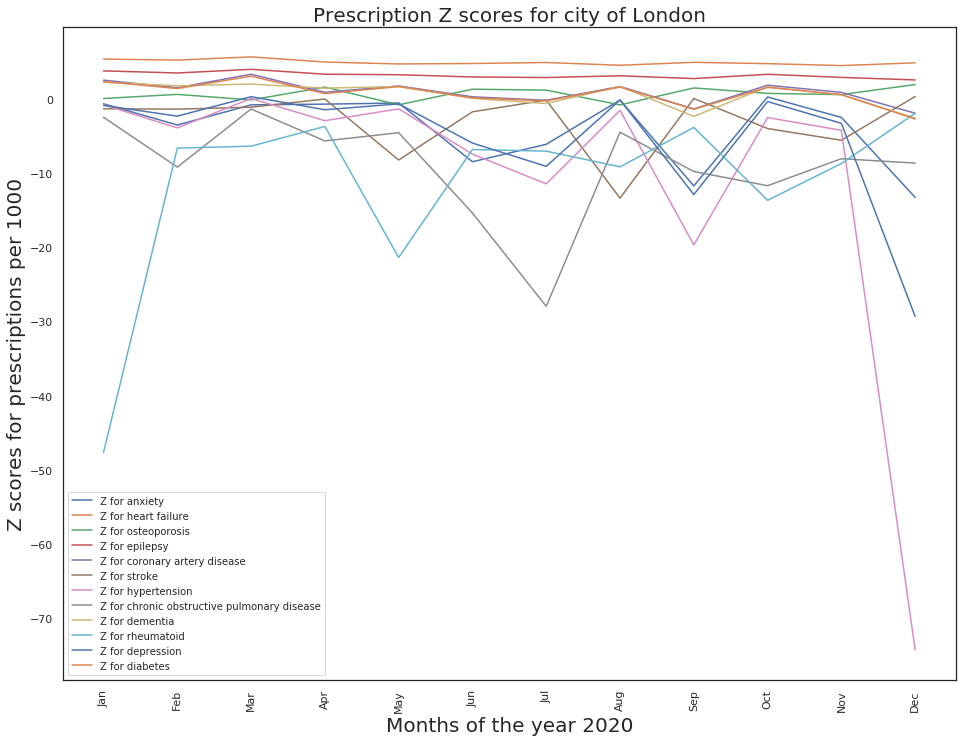

In [134]:
fig, ax = plt.subplots()
fig.set_size_inches(16, 12)
sns.set_style("white")
legend = []
for d in diseaseZ_scores:
    sns.lineplot(y=diseaseZ_scores[d],x=np.arange(0,len(diseaseZ_scores[d]),1))
    legend.append('Z for ' + d)
ax = plt.gca()

plt.xticks(np.arange(0,12,1),month_names,rotation=90)

plt.legend(legend, fontsize = 10)
plt.xlabel("Months of the year 2020",fontsize=20)
plt.ylabel("Z scores for prescriptions per 1000",fontsize=20)
plt.title("Prescription Z scores for city of " + city, fontsize=20)

In [116]:
monthly_dosage_COVID

{u'201907': {u'anxiety': {u'Barnsley': 469.19615830219175,
   u'Basildon': 794.4375822751858,
   u'Basingstoke': 1046.7077106997358,
   u'Bath': 40.752417420088356,
   u'Bedford': 619.882913894345,
   u'Birkenhead': 796.629106016493,
   u'Birmingham': 330.7919560831384,
   u'Blackburn': 635.2835718194237,
   u'Blackpool': 1002.7769519105236,
   u'Bolton': 511.9005855934412,
   u'Bournemouth': 983.1074612288819,
   u'Bracknell': 537.7189120511117,
   u'Bradford': 409.92706224061874,
   u'Brighton and Hove': 975.104678005356,
   u'Bristol': 106.69709481456759,
   u'Burnley': 642.1989272359777,
   u'Burton upon Trent': 532.9949215554543,
   u'Bury': 380.20194706405294,
   u'Cambridge': 591.7419294325514,
   u'Carlisle': 714.0286106935292,
   u'Chatham': 564.1028202678027,
   u'Chelmsford': 701.6301408991594,
   u'Cheltenham': 673.5101482859698,
   u'Chester': 889.806578634977,
   u'Chesterfield': 1002.3361674992732,
   u'Colchester': 917.5319869444801,
   u'Coventry': 670.7532012818458,
 

In [135]:
city = 'London'

d_l = ['anxiety',
 'heart failure',
 'rheumatoid',
 'epilepsy',
 'dementia',
 'stroke',
 'hypertension',
 'diabetes',
 'chronic obstructive pulmonary disease',
#  'obesity',
 'coronary artery disease',
#  'kidney disease',
 'depression',
 'osteoporosis']

# d_l = ['anxiety' , 'depression']

all_covid_months = ['201907','201908','201909','201910','201911','201912','202001', '202002', '202003', '202004', '202005', 
                    '202006', '202007', '202008', '202009', '202010', '202011', '202012','202101','202102',]

disease_timelines = {}
months = monthly_dosage_COVID.keys
for disease in d_l:
    disease_timelines[disease] = []
    for month in monthly_dosage_COVID:
        if city in monthly_dosage_COVID[month][disease]:
            disease_timelines[disease].append(    monthly_dosage_COVID[month][disease][city] )

In [136]:
# disease_timelines

Text(0.5,1,'Prescriptions for city of London')

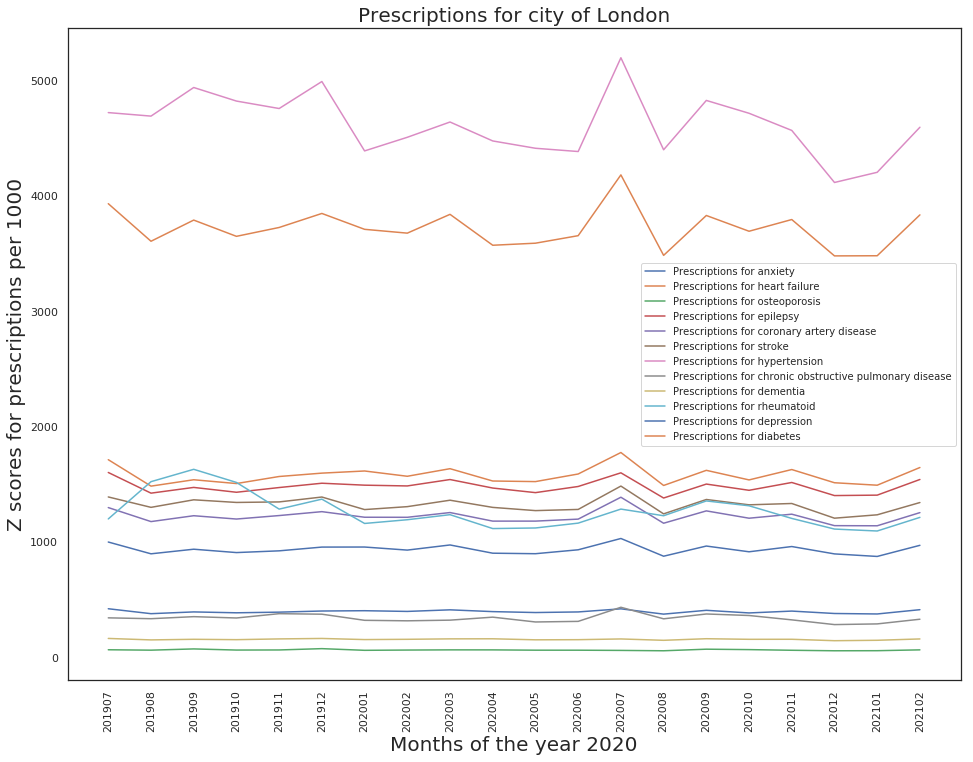

In [139]:
fig, ax = plt.subplots()
fig.set_size_inches(16, 12)
sns.set_style("white")
legend = []
for d in disease_timelines:
    sns.lineplot(y=disease_timelines[d],x=np.arange(0,len(disease_timelines[d]),1))
    legend.append('Prescriptions for ' + d)
ax = plt.gca()

plt.xticks(np.arange(0,20,1),all_covid_months,rotation=90)

plt.legend(legend, fontsize = 10)
plt.xlabel("Months of the year 2020",fontsize=20)
plt.ylabel("Z scores for prescriptions per 1000",fontsize=20)
plt.title("Prescriptions for city of " + city, fontsize=20)

Text(0.5,1,'Prescription Z scores for city of London')

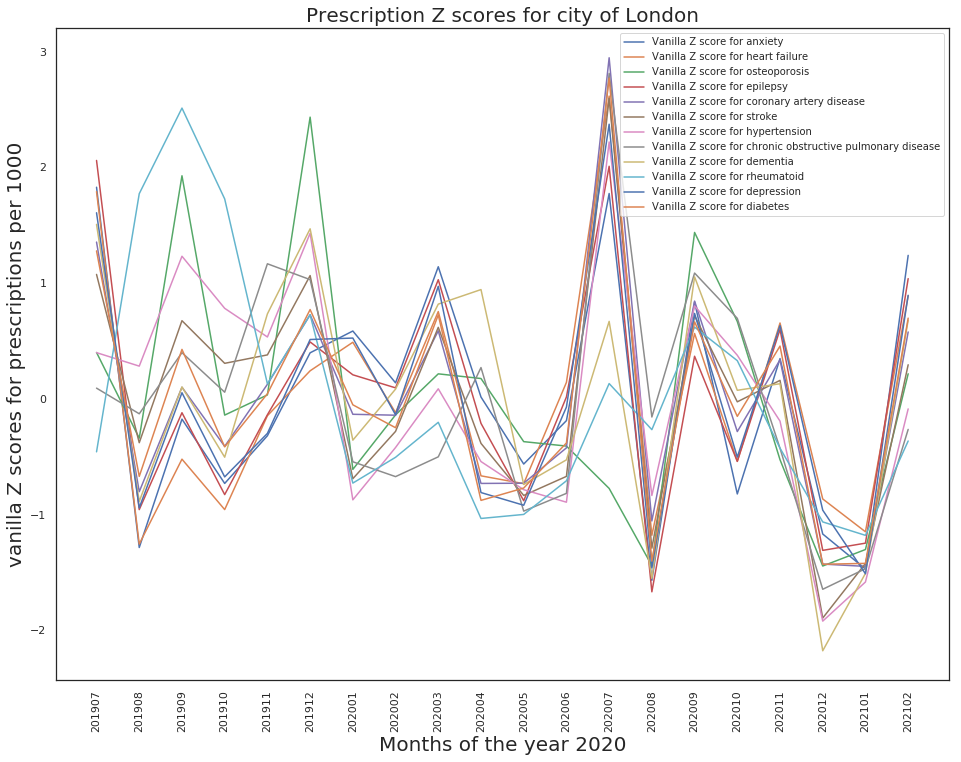

In [138]:
fig, ax = plt.subplots()
fig.set_size_inches(16, 12)
sns.set_style("white")
legend = []
for d in disease_timelines:
    if len(disease_timelines[d])> 0:
        mean = (np.mean(disease_timelines[d]))
        sigma = (np.std(disease_timelines[d]))
        Z_scores = [float(k - mean)/sigma for k in disease_timelines[d]]
        sns.lineplot(y=Z_scores,x=np.arange(0,len(disease_timelines[d]),1))
        legend.append('Vanilla Z score for ' + d)
ax = plt.gca()

plt.xticks(np.arange(0,20,1),all_covid_months,rotation=90)

plt.legend(legend, fontsize = 10)
plt.xlabel("Months of the year 2020",fontsize=20)
plt.ylabel("vanilla Z scores for prescriptions per 1000",fontsize=20)
plt.title("Prescription Z scores for city of " + city, fontsize=20)